<a href="https://colab.research.google.com/github/hakimozcan/Blockchain-Analytics/blob/main/hierarchical_clustering_cryptos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Package

In [ ]:
!pip install cryptocompare

  Preparing metadata (setup.py) ... done
  Created wheel for cryptocompare: filename=cryptocompare-0.7.6-py3-none-any.whl size=6289 sha256=4059d1b3cd4f7fb0ff85966a101fcced17ebc5668af819153c1bc2760d8a5e4b
  Stored in directory: /root/.cache/pip/wheels/97/81/6a/261bc499b9d9bf8b391eea52c90a4746b477539564b0a66c94
Successfully built cryptocompare


# Import Packages

In [ ]:
import cryptocompare
import pandas as pd
import numpy as np

import requests
from tqdm import tqdm

from pandas import json_normalize

import missingno as msno

import matplotlib.pyplot as plt

# Data

## EDA

In [ ]:
coin_data = cryptocompare.get_coin_list()

In [ ]:
coin_df = pd.DataFrame.from_dict(coin_data, orient="index")
coin_df.shape

(8593, 16)

In [ ]:
coin_df.index

Index(['BTCD', 'CRAIG', 'XBS', 'XPY', 'PRC', 'YBC', 'DANK', 'GIVE', 'KOBO',
       'DT',
       ...
       'COMBO', 'ARTP', 'WLD', 'MOG', 'ALLIN', 'DREAM', 'IRIS', 'CONT',
       'MANTLE', 'ARKM'],
      dtype='object', length=8593)

In [ ]:
# Replace 'N/A' with NaN
coin_df.replace('N/A', pd.NA, inplace=True)

# Print the portion of data missing
print((coin_df.isna().mean() * 100).round(1).astype(str)+ ' %')

In [ ]:
coin_df.head()

In [ ]:
coin_df['Description'].head(20)

In [ ]:
import pandas as pd
import re

# Mapping between full names and abbreviations
proof_type_mapping = {
    'Proof of Work': 'PoW',
    'Proof of Stake': 'PoS',
    'Delegated Proof of Stake': 'DPoS',
    'Proof of Authority': 'PoA',
    'Proof of Burn': 'PoB',
    'Proof of Capacity': 'PoC',
    'Proof of Elapsed Time': 'PoET',
    'Proof of Importance': 'PoI',
    'Proof of Stake Time': 'PoST',
    'Proof of Activity': 'PoA',
    'Proof of Stake Velocity': 'PoSV',
    'Proof of Assignment': 'PoA',
    'Proof of Developer': 'PoD',
    'Proof of Existence': 'PoE',
    'Proof of History': 'PoH',
    'Proof of Location': 'PoL',
    'Proof of Ownership': 'PoO',
    'Proof of Play': 'PoP',
    'Proof of Research': 'PoR',
    'Proof of Space': 'PoSpace',
    'Proof of Stake and Trust': 'TPoS',
    'Proof of Transaction': 'PoT',
    'Proof of Weight': 'PoWeight',
}


# Replace full names with abbreviations in the 'Description' column (case-insensitive)
coin_df['Description'] = coin_df['Description'].replace({re.compile(k, re.IGNORECASE): v for k, v in proof_type_mapping.items()}, regex=True)

# Print DataFrame columns to verify the changes
print(coin_df.columns)

In [ ]:
# Get unique values from 'Algorithm' and 'ProofType' columns
proof_types = coin_df['ProofType'].dropna().unique().tolist()

# Define a function to extract information from the description
def extract_info(description, options):
    for opt in options:
        if re.search(rf'\b{opt}\b', description, re.IGNORECASE):
            return opt
    return None

# Apply the function to the 'Description' column where 'Algorithm' and 'ProofType' are NaN
coin_df.loc[coin_df['ProofType'].isna(), 'ProofType'] = coin_df.loc[coin_df['ProofType'].isna(), 'Description'].apply(lambda x: extract_info(str(x), proof_types))

# Display the first few rows of the dataframe
print(coin_df[['Description', 'ProofType', 'Algorithm']].head())

                                             Description ProofType Algorithm
BTCD   Bitcoin Dark (BTCD) is a PoW and PoS hybrid al...   PoW/PoS   SHA-256
CRAIG  CraigCoin (CRAIG) is a 100% pure PoS or PoS al...       PoS       X11
XBS    To create the infrastructure necessary to impl...   PoW/PoS       X11
XPY    Paycoin is an SHA256 cryptocurrency that switc...       PoS   SHA-256
PRC    ProsperCoin is a PoW cryptocurrency with a mod...       PoW    Scrypt


In [ ]:
coin_df.columns

Index(['Id', 'Url', 'ImageUrl', 'ContentCreatedOn', 'Name', 'Symbol',
       'CoinName', 'FullName', 'Description', 'AssetTokenStatus', 'Algorithm',
       'ProofType', 'SortOrder', 'Sponsored', 'Taxonomy', 'Rating'],
      dtype='object')

In [ ]:
# Extract all unique keys from the dictionaries in the 'Taxonomy' column

unique_keys = set(key for dic in coin_df['Taxonomy'] for key in dic.keys())
print(unique_keys)

{'FINMA', 'FCA', 'Access', 'Industry', 'CollateralType', 'CollateralizedAssetType', 'CollateralInfo', 'CollateralizedAsset'}


In [ ]:
unique_keys = set(key for dic in coin_df['Rating'] for key in dic.keys())
print(unique_keys)

{'Weiss'}


In [ ]:
# Extract the unique inner keys from the nested dictionaries in the 'Rating' column
unique_inner_keys = set()
coin_df['Rating'].apply(lambda x: unique_inner_keys.update({k for d in x.values() for k in d.keys()}))
print(unique_inner_keys)

{'Rating', 'MarketPerformanceRating', 'TechnologyAdoptionRating'}


In [ ]:
coin_df.index

Index(['BTCD', 'CRAIG', 'XBS', 'XPY', 'PRC', 'YBC', 'DANK', 'GIVE', 'KOBO',
       'DT',
       ...
       'COMBO', 'ARTP', 'WLD', 'MOG', 'ALLIN', 'DREAM', 'IRIS', 'CONT',
       'MANTLE', 'ARKM'],
      dtype='object', length=8593)

In [ ]:
# Normalize the dictionaries into dataframes
taxonomy_df = json_normalize(coin_df['Taxonomy']).replace('', np.nan)
rating_df = json_normalize(coin_df['Rating']).replace('', np.nan)

# Reset the index for all dataframes for seamless merging.
coin_df = coin_df.reset_index(drop=True)
taxonomy_df = taxonomy_df.reset_index(drop=True)
rating_df = rating_df.reset_index(drop=True)

# Join the new dataframes to the original dataframe
coin_df = coin_df.join(taxonomy_df).join(rating_df)

# Drop the original "Taxonomy" and "Rating" columns
coin_df = coin_df.drop(columns=['Taxonomy', 'Rating'])

# Display the first few rows of the updated dataframe
coin_df.head()

In [ ]:
coin_df.columns

Index(['Id', 'Url', 'ImageUrl', 'ContentCreatedOn', 'Name', 'Symbol',
       'CoinName', 'FullName', 'Description', 'AssetTokenStatus', 'Algorithm',
       'ProofType', 'SortOrder', 'Sponsored', 'Access', 'FCA', 'FINMA',
       'Industry', 'CollateralizedAsset', 'CollateralizedAssetType',
       'CollateralType', 'CollateralInfo', 'Weiss.Rating',
       'Weiss.TechnologyAdoptionRating', 'Weiss.MarketPerformanceRating'],
      dtype='object')

In [ ]:
coin_df.shape

(8593, 25)

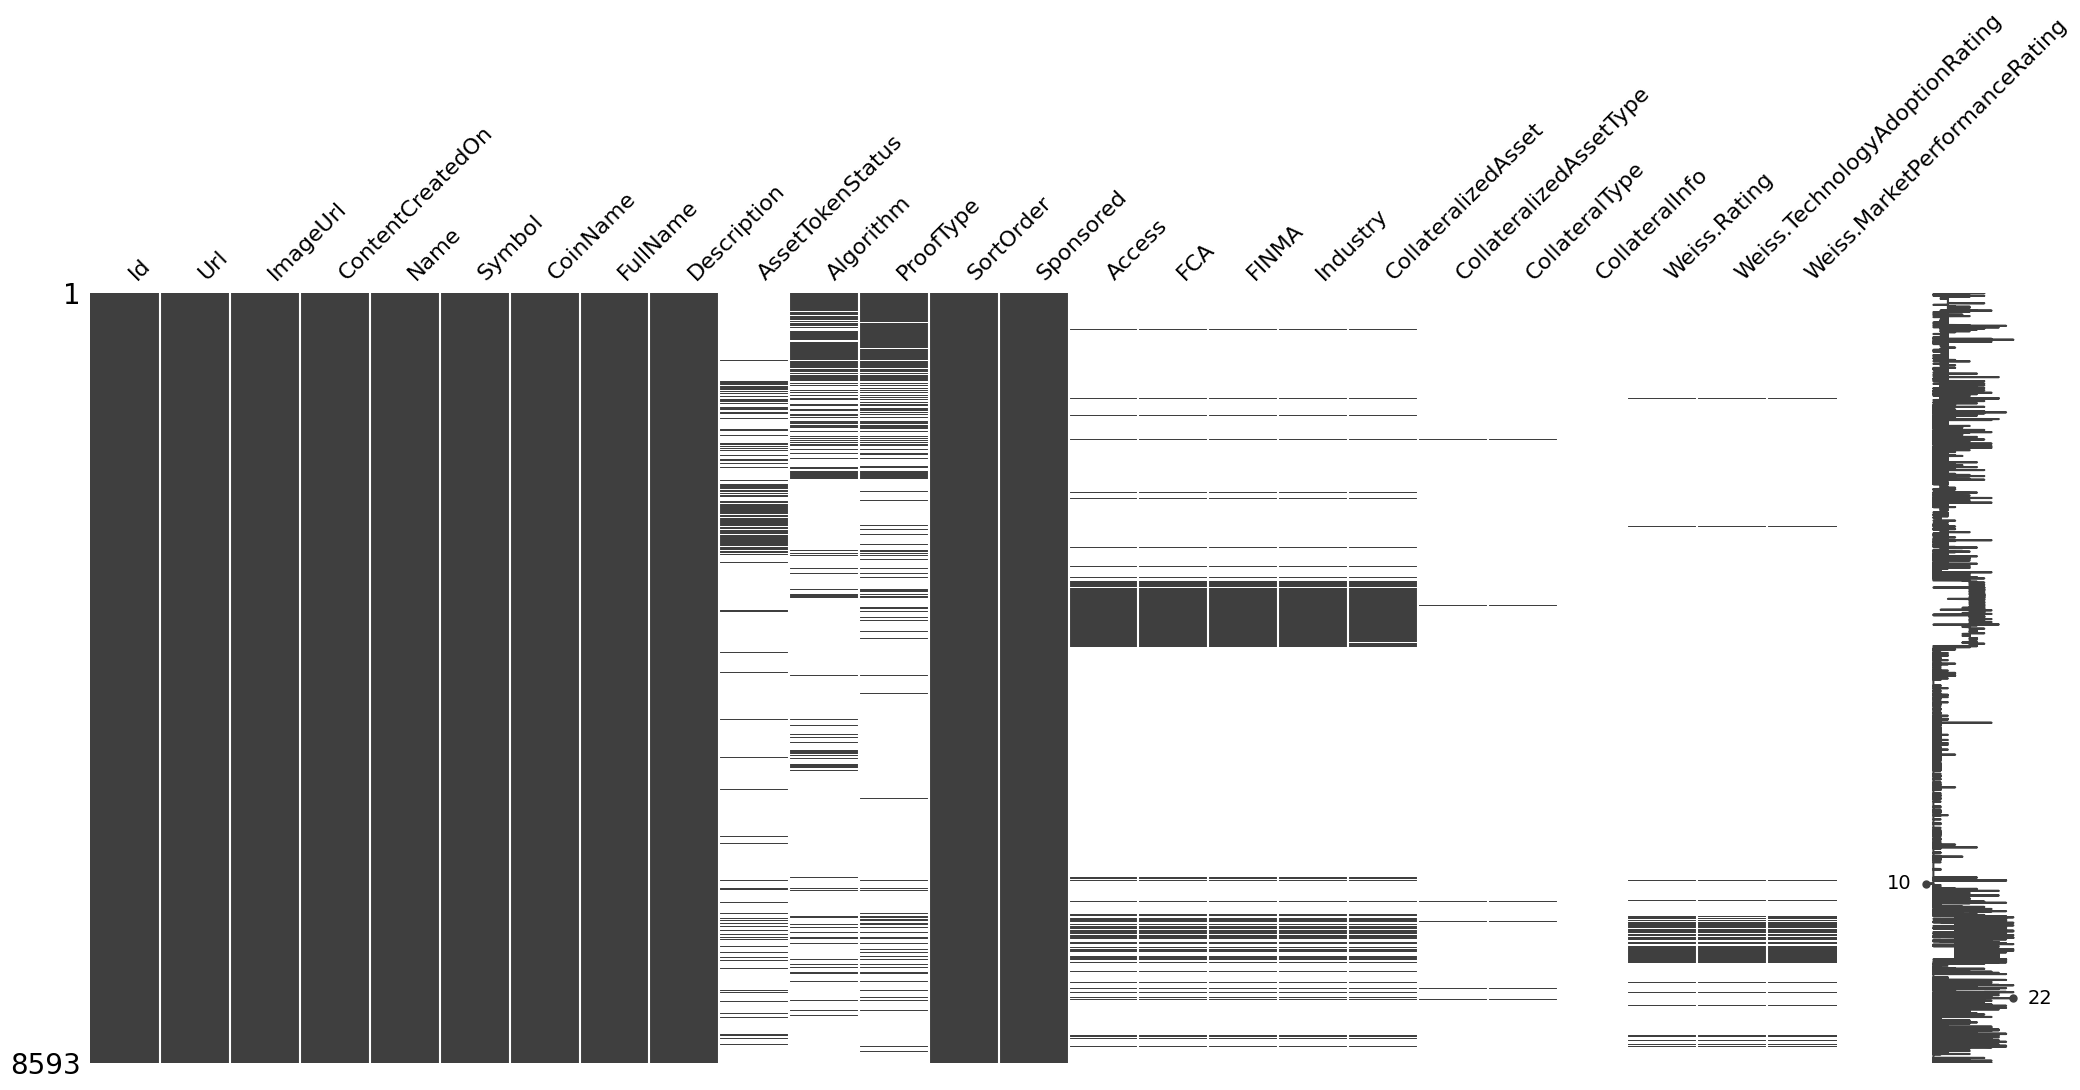

In [ ]:
# Create a matrix plot to visualize the patterns of missingness in data.
msno.matrix(coin_df)
plt.show()

# The sparkline at right summarizes the general shape of the data completeness
# and points out the rows with the maximum and minimum nullity in the dataset.

## Prepare Data

In [ ]:
df = coin_df[['Symbol', 'CoinName', 'Algorithm', 'ProofType', 'Access', 'FINMA']].dropna().copy()
df.set_index('Symbol', inplace=True)
df.head()

,CoinName,Algorithm,ProofType,Access,FINMA
Symbol,,,,,
BTCD,BitcoinDark,SHA-256,PoW/PoS,Permissionless,Payment
BEAN,BeanCash,SHA-256,PoW/PoS,Permissionless,Payment
MEDIT,MediterraneanCoin,HybridScryptHash256,PoW,Permissioned,Utility
BAY,BitBay,PoS,PoS,Permissionless,Utility
EMC,Emercoin,SHA-256,PoW/PoS,Permissionless,Utility


In [ ]:
df.shape

(120, 5)

In [ ]:
# Print the portion of data missing
print((df.isna().mean() * 100).round(1).astype(str)+ ' %')

CoinName     0.0 %
Algorithm    0.0 %
ProofType    0.0 %
Access       0.0 %
FINMA        0.0 %
dtype: object


In [ ]:
# Create an empty dictionary to store the unique values and their counts for each column
unique_values_counts = {}

# Loop through each column in the DataFrame
for column in df.columns:
    # Get unique values and their counts for the current column
    unique_values_counts[column] = df[column].value_counts()

# Printing the results
for column, value_counts in unique_values_counts.items():
    print(f"Column: {column}")
    print(value_counts)
    print("-----------------------")

Column: CoinName
BitcoinDark    1
BeanCash       1
Groestlcoin    1
Komodo         1
Dash           1
              ..
Varius         1
BZLCoin        1
Neetcoin       1
PEPS Coin      1
Ergo           1
Name: CoinName, Length: 120, dtype: int64
-----------------------
Column: Algorithm
Scrypt                   15
SHA-256                  14
Quark                    12
DPoS                      7
X11                       5
Equihash                  5
X13                       4
PoS                       3
Ethash                    3
BLAKE256                  2
C31                       2
Multiple                  2
VeChainThor Authority     2
Blake2b                   2
RandomX                   2
POS 3.0                   2
MTP                       1
NeoScrypt                 1
Loopchain                 1
KECCAK                    1
BMW512 / Echo512          1
EtcHash                   1
Groestl                   1
ECC 256K1                 1
Equihash210,9             1
SHA-512     

In [ ]:
# and 'threshold' is the maximum number of times a category can appear to be considered rare
threshold = 3

# Create an empty dictionary to store the unique values and their counts for each column
unique_values_counts = {}

# Loop through each column in the DataFrame
for column in df.columns[1:]:
    # Get unique values and their counts for the current column
    value_counts = df[column].value_counts()

    # Filter out unique values with counts below the minimum count
    value_counts = value_counts[value_counts >= threshold]

    # Delete rows with unique values that have counts less than the minimum count
    unique_values_to_keep = value_counts.index.tolist()
    df = df[df[column].isin(unique_values_to_keep)]

    unique_values_counts[column] = value_counts

# Printing the results
for column, value_counts in unique_values_counts.items():
    print(f"Column: {column}")
    print(value_counts)
    print("-----------------------")

In [ ]:
df.shape

(62, 5)

Label Encoding: Label encoding assigns a unique numerical label to each category in a categorical variable. It preserves the ordinal relationship between categories if present. For example, “Red” may be encoded as 1, “Green” as 2, and “Blue” as 3.


One-Hot Encoding: One-hot encoding converts each category in a categorical variable into a binary vector. It creates new binary columns for each category, representing the presence or absence of the category. Each category is mutually exclusive. For example, “Red” may be encoded as [1, 0, 0], “Green” as [0, 1, 0], and “Blue” as [0, 0, 1].

Reference: https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/

In [ ]:
# Perform one-hot encoding using pandas.get_dummies()
df_dum = pd.get_dummies(df)
df_dum.columns

In [ ]:
df_dum.isna().any()

In [ ]:
df.to_csv("coin_data_final.csv")

In [ ]:
from google.colab import files
files.download("coin_data_final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Outlier Detection

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
import itertools

hyperparameters = {
    'n_neighbors': [3, 5],
    'metric': ['jaccard', 'dice', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'yule'],
    'contamination': [0.1, 0.2, 0.3]
}

# The `hyperparameters` dictionary keeps track of the hyperparameters used for outlier detection.
# - "n_neighbors": Number of neighbors considered for local density calculation.
# - "algorithm": Algorithm used to compute the nearest neighbors
# - "metric": Distance metric for data point distances.
# - "contamination": Expected proportion of outliers.

# List to store outlier IDs and corresponding parameter combinations
outlier_results = []
common_outlier_ids = set(df_dum.index)  # Initialize with all IDs in the dataset

# Iterate over all combinations of hyperparameters
for params in itertools.product(*hyperparameters.values()):
    hyperparameter_combination = dict(zip(hyperparameters.keys(), params))

    # Define the LOF model and fit it to the data using the current hyperparameters
    lof = LocalOutlierFactor(**hyperparameter_combination)
    data = np.array(df_dum, dtype=bool)  # Select boolean columns
    lof.fit(data)

    # Get the LOF scores for each row
    lof_scores = lof.negative_outlier_factor_

    # Specify the threshold
    threshold = -2

    # Create a boolean mask for the outlier rows
    outlier_mask = lof_scores < threshold

    # Get the IDs of outlier rows
    outlier_ids = df_dum.index[outlier_mask].tolist()

    # Check if outlier_ids is not empty before appending to the results
    if outlier_ids:
        # Store the outlier IDs and corresponding parameter combinations
        outlier_results.append((outlier_ids, hyperparameter_combination))
        # Update common_outlier_ids with the common IDs from current iteration
        common_outlier_ids.intersection_update(outlier_ids)

# Print the outlier IDs and corresponding parameter combinations
for outlier_ids, parameters in outlier_results:
    parameter_values = list(parameters.values())
    print(f"Outliers: {outlier_ids}, Parameters: {parameter_values}")

# Print the set of all outlier IDs
print(f"\nSet of All Outlier IDs: {common_outlier_ids}")

Outliers: ['PURA', 'LOBS', 'KSH', 'HTDF', 'ERK', 'STEEP', 'NEETCOIN', 'VARIUS', 'AGET', 'GOSS', 'GIO', 'RPD', 'PENG', 'WCC', 'RHP', 'AZBI', 'MTRG', 'FLS', 'BLOCKN', 'XVG', 'WAXP', 'PIVX', 'STEEM', 'AR', 'EOSC', 'DGB', 'SLS'], Parameters: [3, 'jaccard', 0.1]
Outliers: ['PURA', 'LOBS', 'KSH', 'HTDF', 'ERK', 'STEEP', 'NEETCOIN', 'VARIUS', 'AGET', 'GOSS', 'GIO', 'RPD', 'PENG', 'WCC', 'RHP', 'AZBI', 'MTRG', 'FLS', 'BLOCKN', 'XVG', 'WAXP', 'PIVX', 'STEEM', 'AR', 'EOSC', 'DGB', 'SLS'], Parameters: [3, 'jaccard', 0.2]
Outliers: ['PURA', 'LOBS', 'KSH', 'HTDF', 'ERK', 'STEEP', 'NEETCOIN', 'VARIUS', 'AGET', 'GOSS', 'GIO', 'RPD', 'PENG', 'WCC', 'RHP', 'AZBI', 'MTRG', 'FLS', 'BLOCKN', 'XVG', 'WAXP', 'PIVX', 'STEEM', 'AR', 'EOSC', 'DGB', 'SLS'], Parameters: [3, 'jaccard', 0.3]
Outliers: ['PURA', 'LOBS', 'KSH', 'HTDF', 'ERK', 'STEEP', 'NEETCOIN', 'VARIUS', 'AGET', 'GOSS', 'GIO', 'RPD', 'PENG', 'WCC', 'RHP', 'AZBI', 'MTRG', 'FLS', 'BLOCKN', 'XVG', 'WAXP', 'PIVX', 'STEEM', 'AR', 'EOSC', 'DGB', 'SLS'], 

In [ ]:
# create a new data frame with only the non-outlier rows
non_outlier_ids = df_dum.index.difference(common_outlier_ids)
df_no_outlier = df_dum.loc[non_outlier_ids]
df_no_outlier.shape

(85, 14)

In [ ]:
df_no_outlier.isna().any().sum()

0

# No Outlier Detection

In [ ]:
df_no_outlier = df_dum.copy()

# HAC

## Hyperparameter Tuning

See the [pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist) function for a list of valid distance metrics that can be used scipy's hierarchical clustering

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html


https://github.com/scipy/scipy/blob/v1.11.1/scipy/spatial/distance.py#L1903-L2233

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist


https://docs.scipy.org/doc/scipy/reference/spatial.distance.html

In [ ]:
# Import the fcluster and linkage functions
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import silhouette_samples, silhouette_score
import itertools

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples

def hierarchical_clustering_exhaustive_search(data, hyperparameters):
    results = {}
    labels_dict = {}  # Store labels for each combination

    # Generate all combinations of hyperparameters
    parameter_combinations = list(itertools.product(*hyperparameters.values()))

    for combination in parameter_combinations:

        # Perform hierarchical clustering with the current combination of hyperparameters
        linkage_matrix = linkage(data, method=combination[0], metric=combination[1])
        labels = fcluster(linkage_matrix, combination[2], criterion=combination[3])

        try:
            # Check if there is any empty cluster
            if labels.max() == 1 or len(np.unique(labels)) < combination[2]:
                # Skip this combination if it produces empty clusters or only one cluster
                continue

            # Compute the general silhouette score
            silhouette_score_val = silhouette_score(data, labels, metric=combination[1]).round(4)

            # Store the current combination and its corresponding score in the dictionary
            results[combination] = silhouette_score_val

            # Store the labels for this combination
            labels_dict[combination] = labels

        except ValueError:
            # Skip this combination if any other ValueErrors occur
            continue

    # Sort the combinations and scores in descending order of scores
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

    return sorted_results, labels_dict



# Define your hyperparameters
hyperparameters = {
    'method': ['single', 'complete', 'average'],  # Different linkage methods
    'metric': ['jaccard', 'dice', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'yule'], # Different distance metrics
    'n_clusters': list(range(2, 6)),                          # Cluster size
    'criterion': ['distance', 'maxclust']          # Different criteria for forming flat clusters
}


data = np.array(df_no_outlier, dtype=bool)

# Perform hierarchical clustering with exhaustive search
sorted_combinations, labels_dict = hierarchical_clustering_exhaustive_search(data, hyperparameters)

# Print the top 20 combinations and their scores
for i, combination in enumerate(sorted_combinations[:50]):
    params, score = combination
    print(f"Combination {i+1}: {params}, Score: {score}")

Combination 1: ('average', 'yule', 4, 'maxclust'), Score: 0.7928
Combination 2: ('average', 'yule', 3, 'maxclust'), Score: 0.7165
Combination 3: ('average', 'yule', 5, 'maxclust'), Score: 0.7074
Combination 4: ('complete', 'yule', 2, 'maxclust'), Score: 0.6983
Combination 5: ('average', 'dice', 4, 'maxclust'), Score: 0.562
Combination 6: ('average', 'dice', 5, 'maxclust'), Score: 0.5328
Combination 7: ('average', 'rogerstanimoto', 4, 'maxclust'), Score: 0.5242
Combination 8: ('average', 'sokalmichener', 4, 'maxclust'), Score: 0.5242
Combination 9: ('average', 'dice', 3, 'maxclust'), Score: 0.5177
Combination 10: ('average', 'rogerstanimoto', 5, 'maxclust'), Score: 0.5025
Combination 11: ('average', 'sokalmichener', 5, 'maxclust'), Score: 0.5025
Combination 12: ('average', 'jaccard', 4, 'maxclust'), Score: 0.4873
Combination 13: ('average', 'rogerstanimoto', 3, 'maxclust'), Score: 0.4774
Combination 14: ('average', 'sokalmichener', 3, 'maxclust'), Score: 0.4774
Combination 15: ('average

## Evaluating Hyperparameter Tuning using Silhouette Plots

Combination 1:
Hyperparameters: ('average', 'yule', 4, 'maxclust')
Score: 0.7928



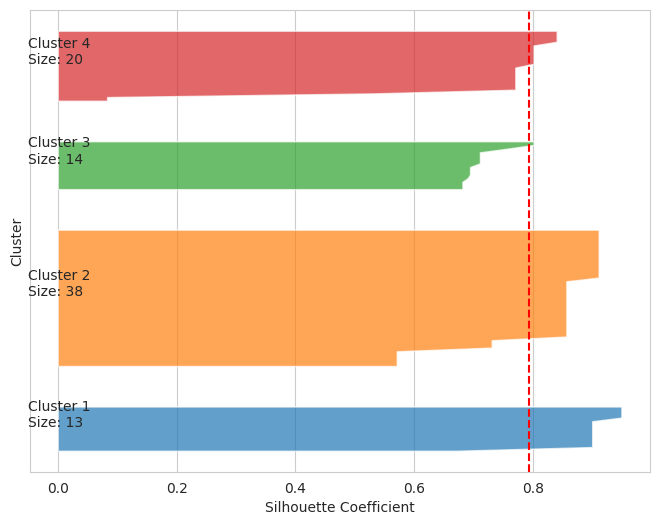

Combination 2:
Hyperparameters: ('average', 'yule', 3, 'maxclust')
Score: 0.7165



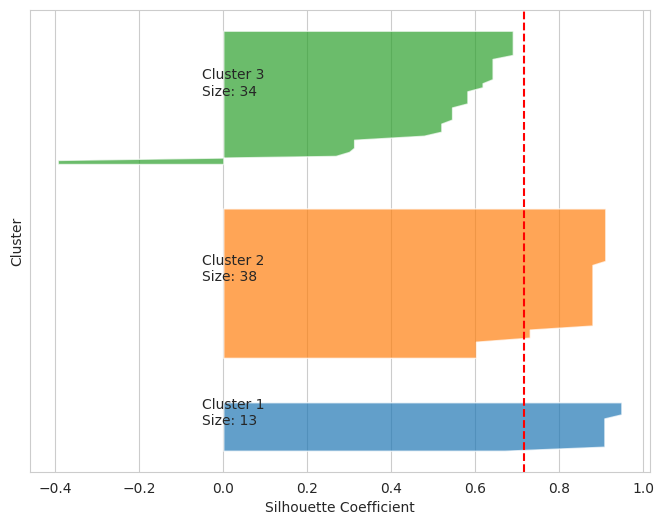

Combination 3:
Hyperparameters: ('average', 'yule', 5, 'maxclust')
Score: 0.7074



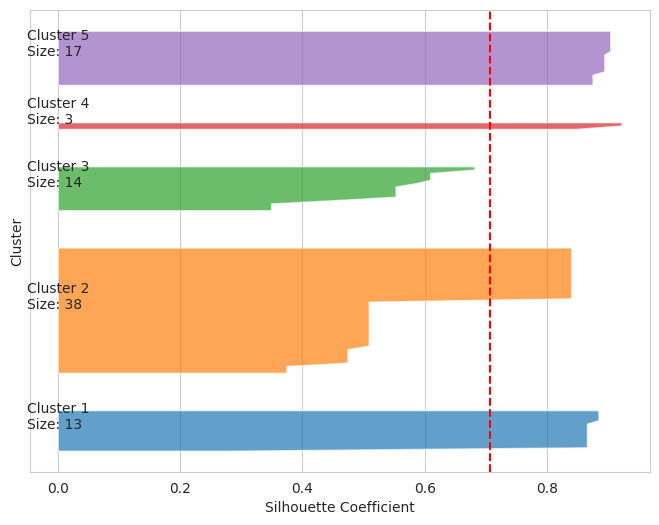

Combination 4:
Hyperparameters: ('complete', 'yule', 2, 'maxclust')
Score: 0.6983



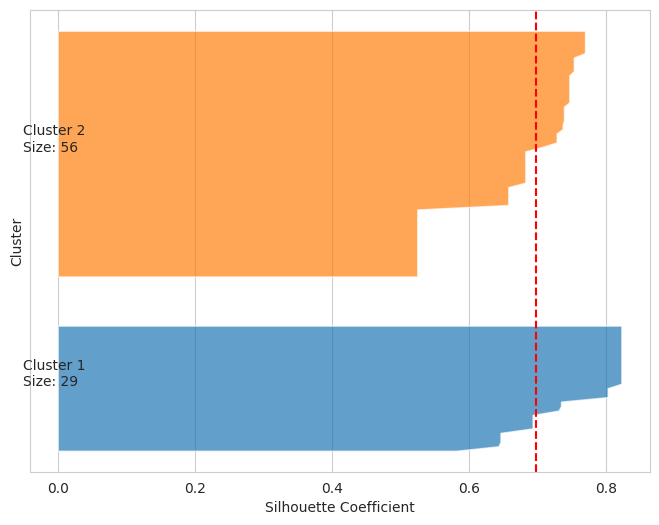

Combination 5:
Hyperparameters: ('average', 'dice', 4, 'maxclust')
Score: 0.562



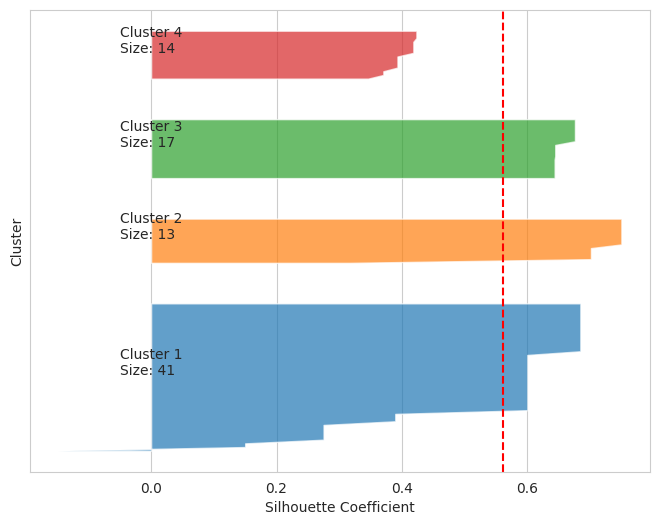

Combination 6:
Hyperparameters: ('average', 'dice', 5, 'maxclust')
Score: 0.5328



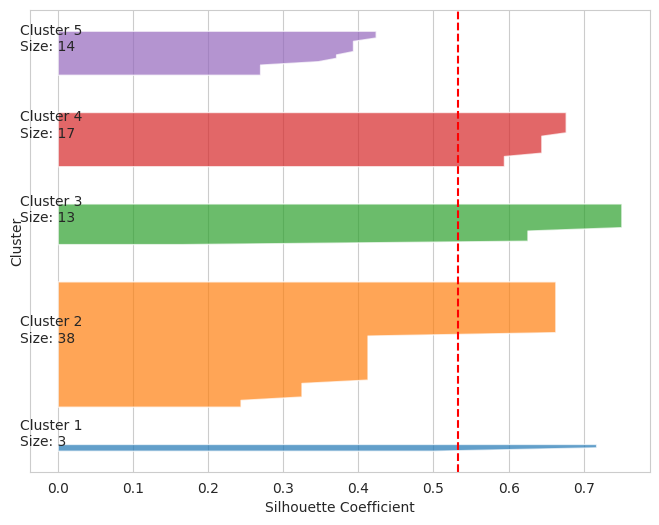

Combination 7:
Hyperparameters: ('average', 'rogerstanimoto', 4, 'maxclust')
Score: 0.5242



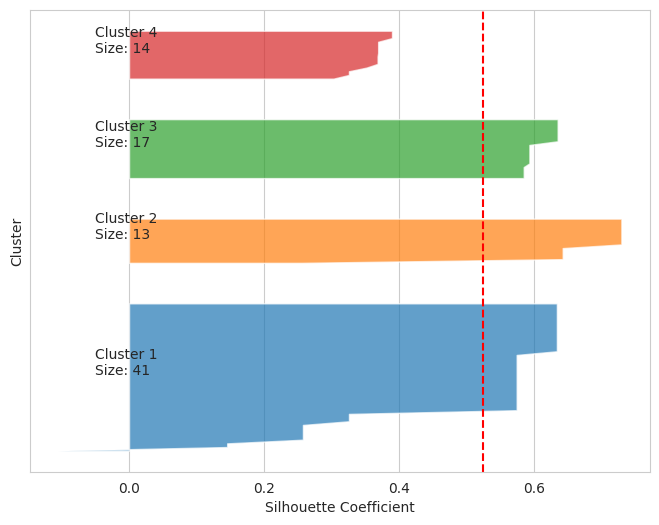

Combination 8:
Hyperparameters: ('average', 'sokalmichener', 4, 'maxclust')
Score: 0.5242



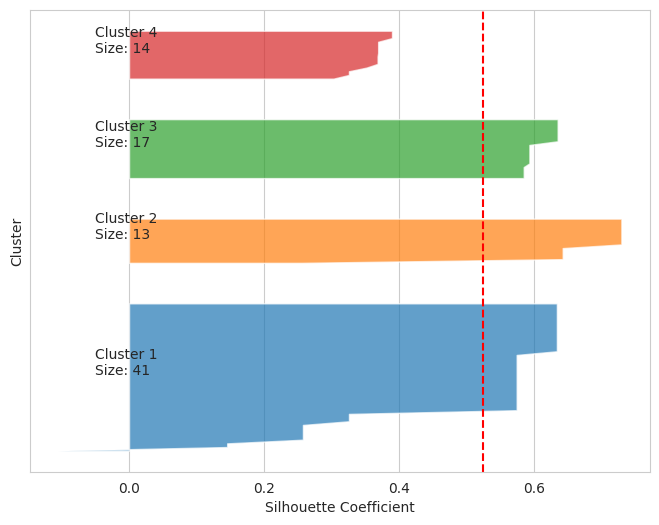

Combination 9:
Hyperparameters: ('average', 'dice', 3, 'maxclust')
Score: 0.5177



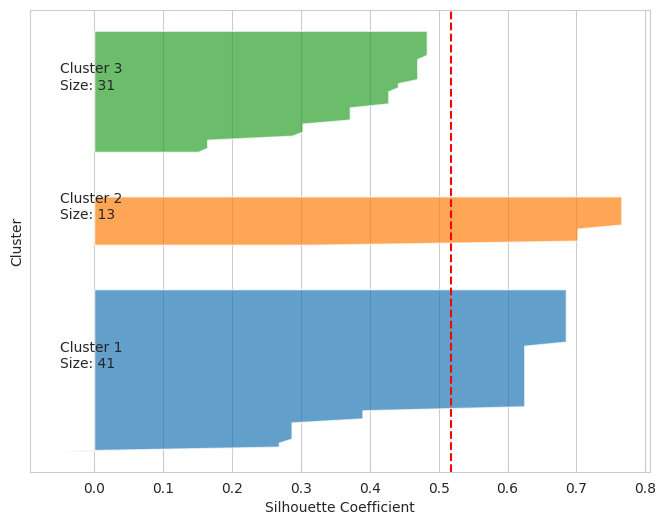

Combination 10:
Hyperparameters: ('average', 'rogerstanimoto', 5, 'maxclust')
Score: 0.5025



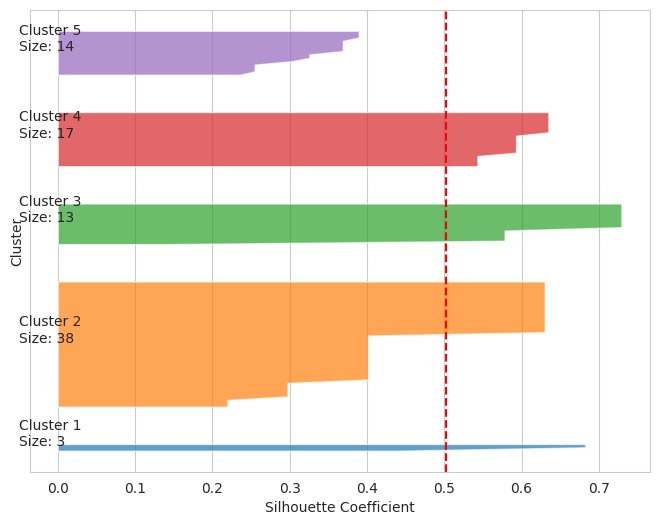

Combination 11:
Hyperparameters: ('average', 'sokalmichener', 5, 'maxclust')
Score: 0.5025



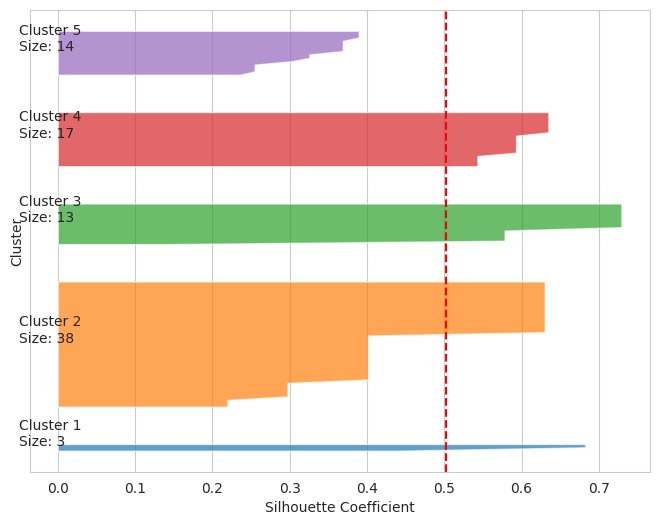

Combination 12:
Hyperparameters: ('average', 'jaccard', 4, 'maxclust')
Score: 0.4873



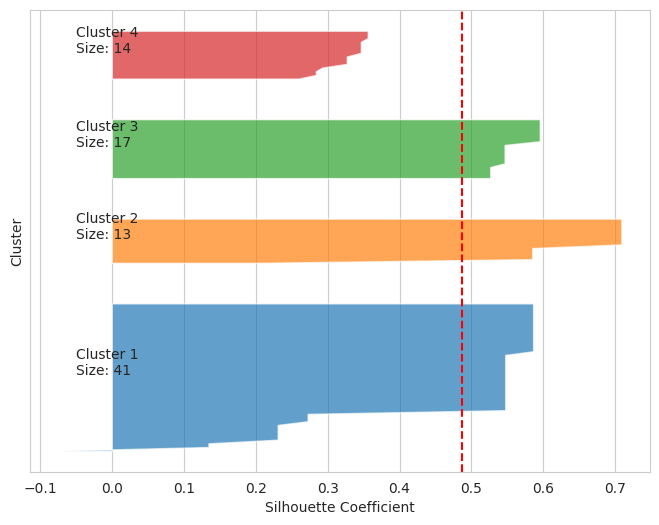

Combination 13:
Hyperparameters: ('average', 'rogerstanimoto', 3, 'maxclust')
Score: 0.4774



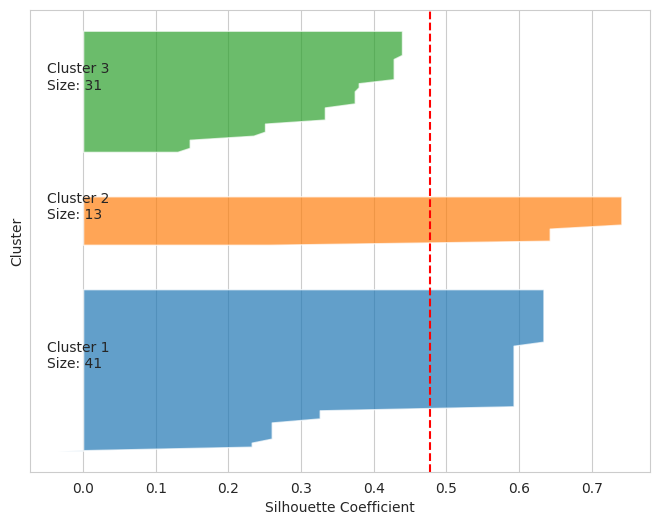

Combination 14:
Hyperparameters: ('average', 'sokalmichener', 3, 'maxclust')
Score: 0.4774



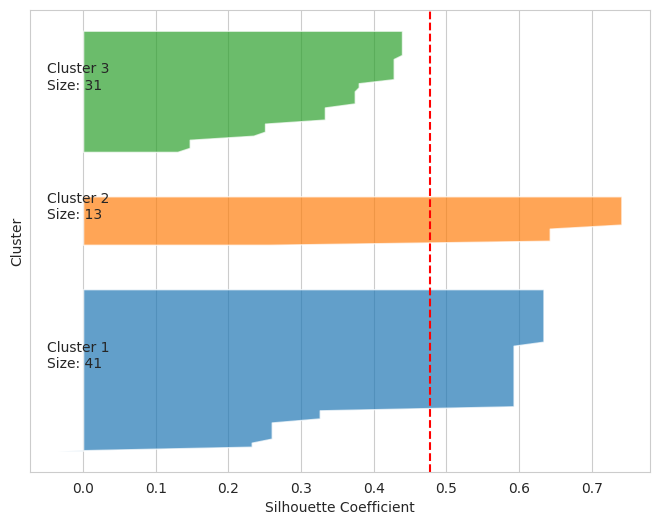

Combination 15:
Hyperparameters: ('average', 'jaccard', 5, 'maxclust')
Score: 0.4725



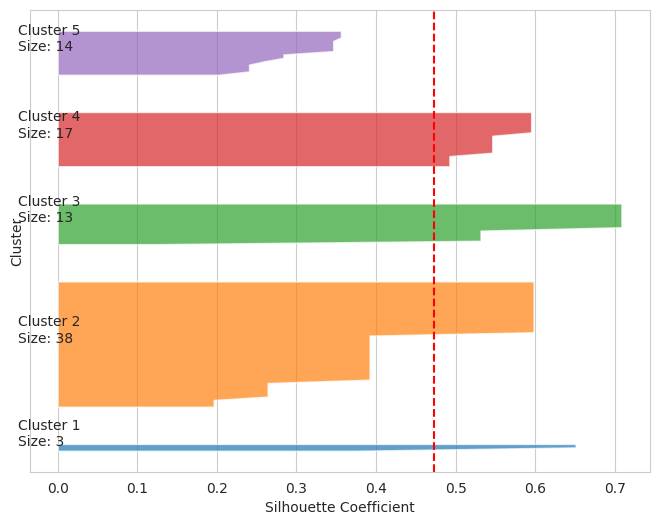

Combination 16:
Hyperparameters: ('average', 'yule', 2, 'maxclust')
Score: 0.4638



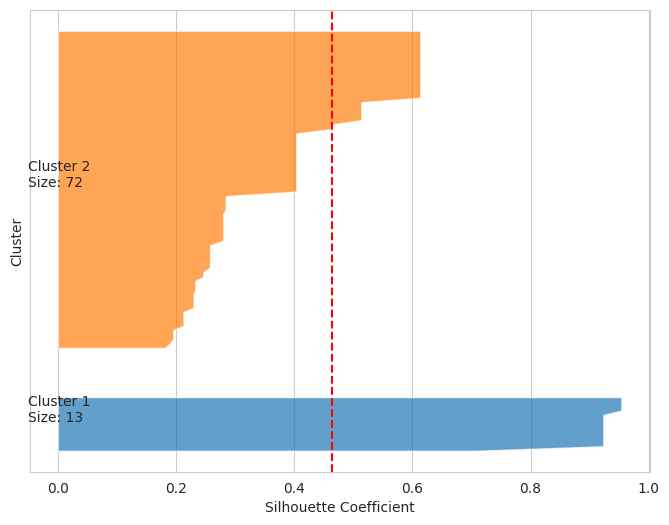

Combination 17:
Hyperparameters: ('average', 'jaccard', 3, 'maxclust')
Score: 0.4402



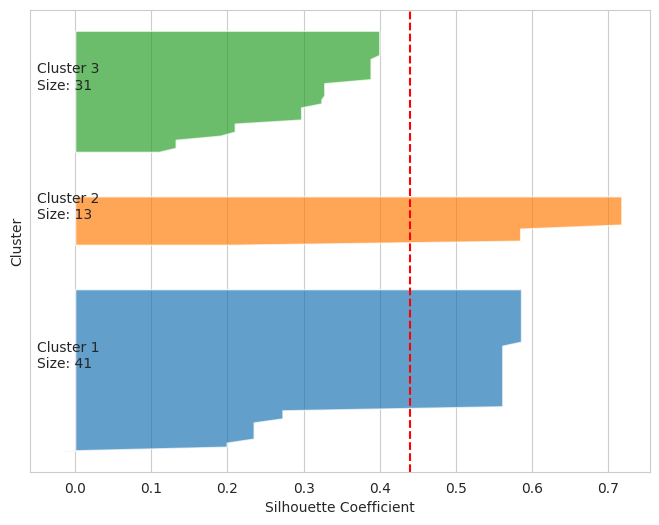

Combination 18:
Hyperparameters: ('average', 'sokalsneath', 4, 'maxclust')
Score: 0.4166



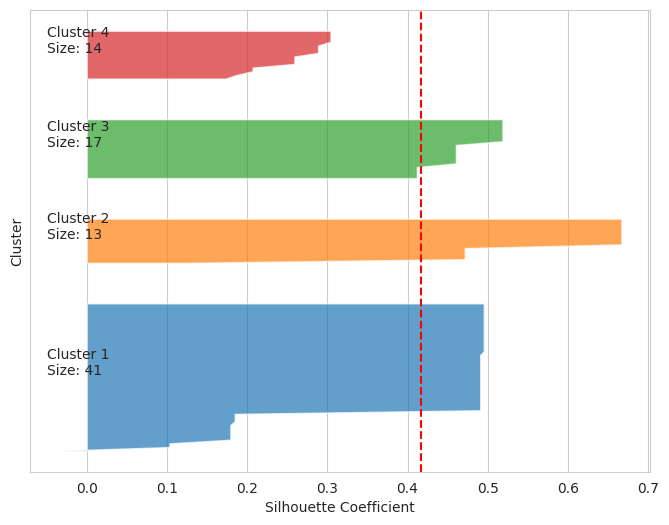

Combination 19:
Hyperparameters: ('average', 'dice', 2, 'maxclust')
Score: 0.4148



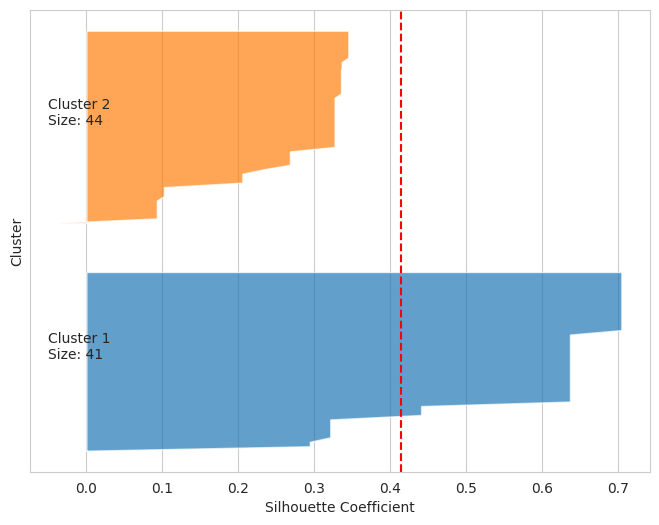

Combination 20:
Hyperparameters: ('average', 'sokalsneath', 5, 'maxclust')
Score: 0.4147



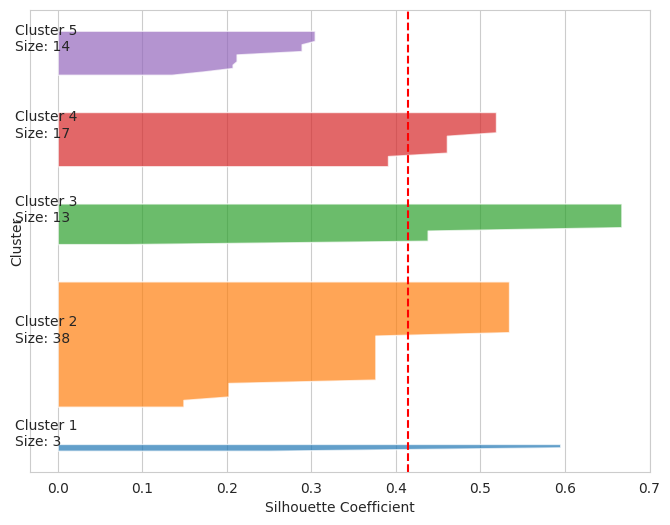

Combination 21:
Hyperparameters: ('complete', 'dice', 2, 'maxclust')
Score: 0.4083



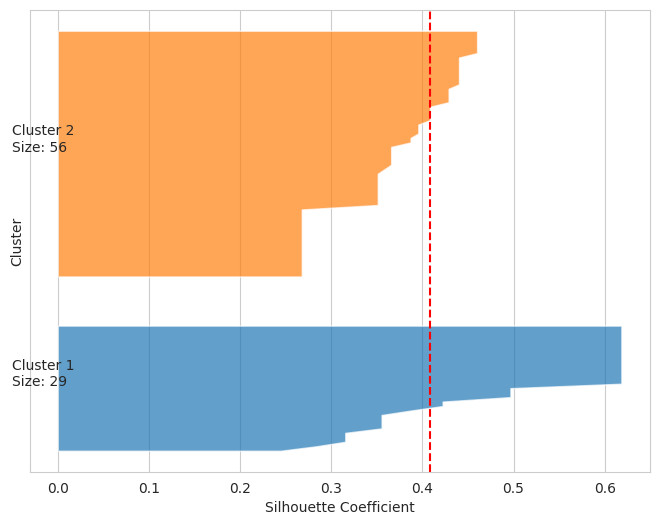

Combination 22:
Hyperparameters: ('average', 'rogerstanimoto', 2, 'maxclust')
Score: 0.3797



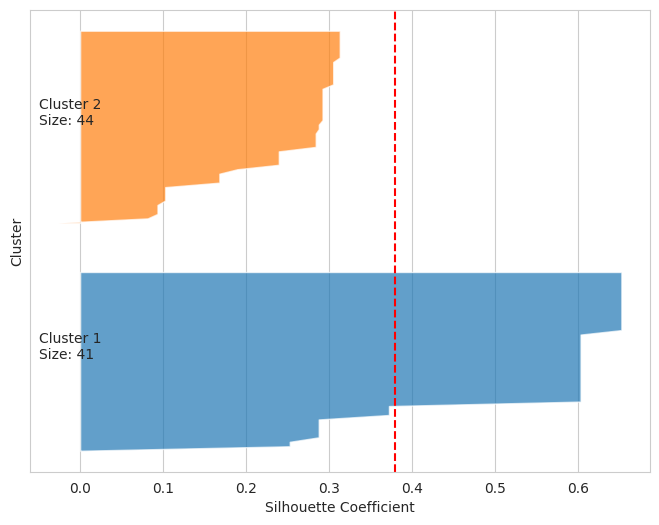

Combination 23:
Hyperparameters: ('average', 'sokalmichener', 2, 'maxclust')
Score: 0.3797



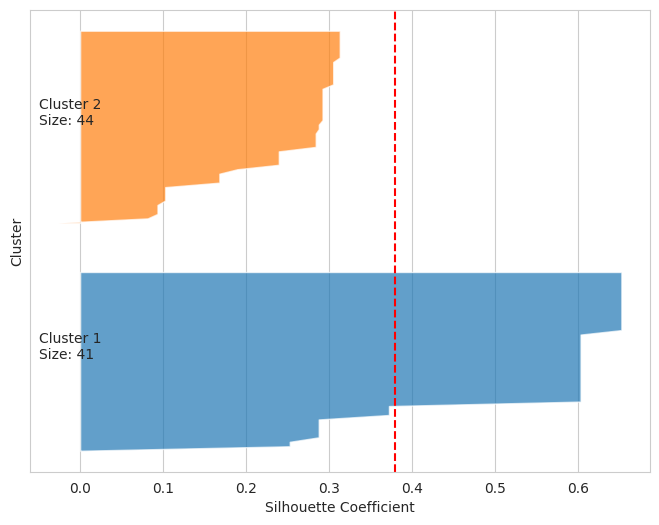

Combination 24:
Hyperparameters: ('average', 'sokalsneath', 3, 'maxclust')
Score: 0.3707



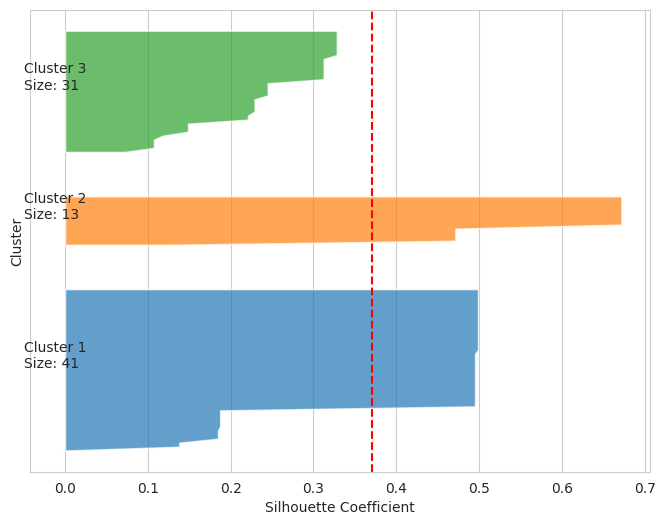

Combination 25:
Hyperparameters: ('complete', 'rogerstanimoto', 2, 'maxclust')
Score: 0.3565



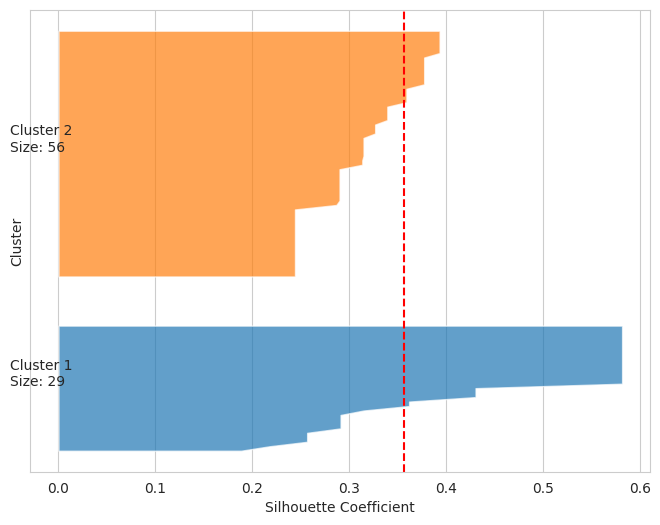

Combination 26:
Hyperparameters: ('complete', 'sokalmichener', 2, 'maxclust')
Score: 0.3565



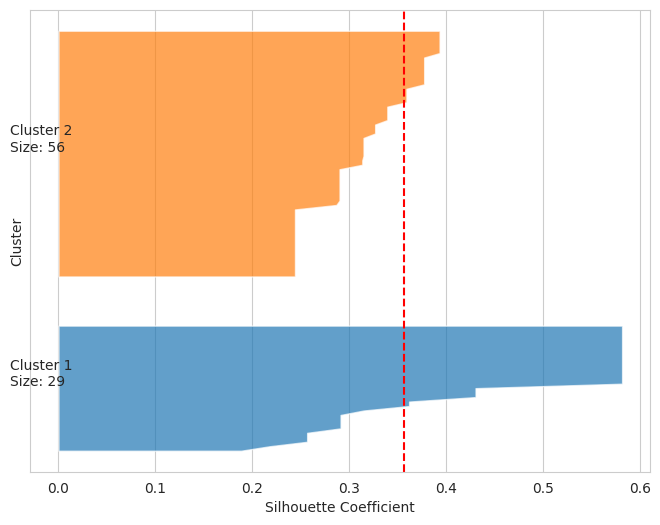

Combination 27:
Hyperparameters: ('average', 'jaccard', 2, 'maxclust')
Score: 0.3476



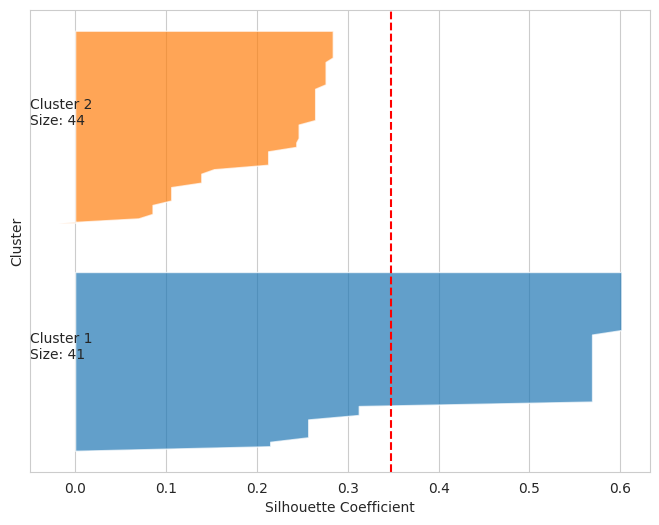

Combination 28:
Hyperparameters: ('complete', 'jaccard', 2, 'maxclust')
Score: 0.316



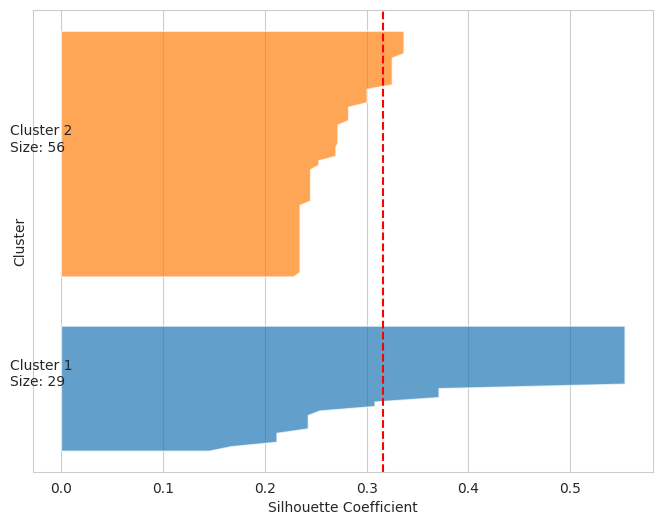

Combination 29:
Hyperparameters: ('average', 'sokalsneath', 2, 'maxclust')
Score: 0.2886



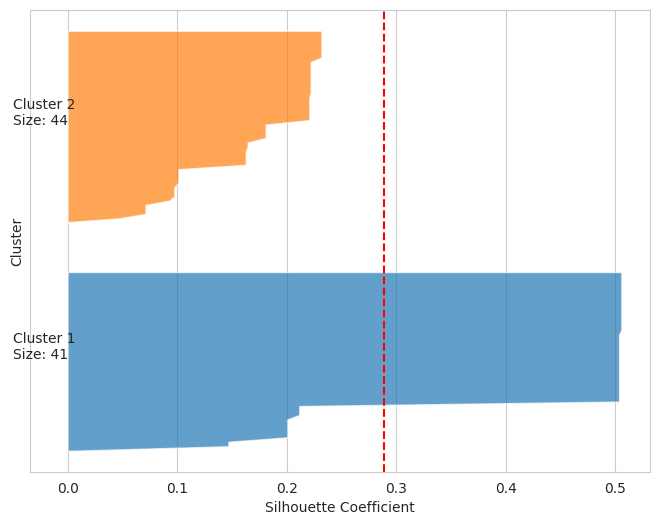

Combination 30:
Hyperparameters: ('complete', 'sokalsneath', 2, 'maxclust')
Score: 0.2558



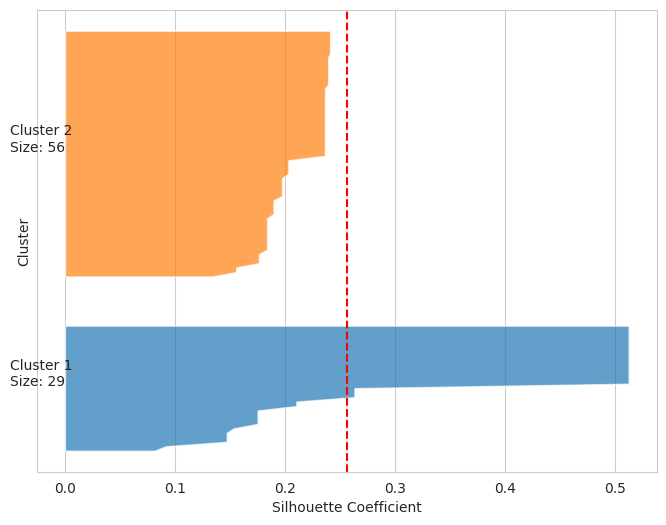

Combination 31:
Hyperparameters: ('average', 'russellrao', 4, 'maxclust')
Score: 0.0924



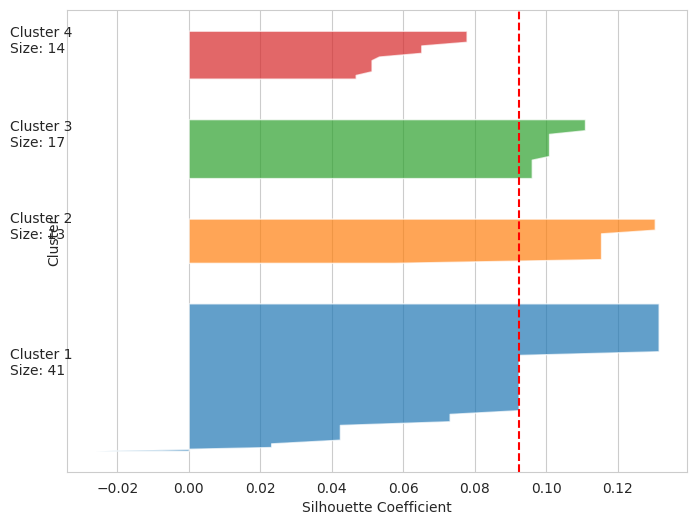

Combination 32:
Hyperparameters: ('average', 'russellrao', 3, 'maxclust')
Score: 0.0908



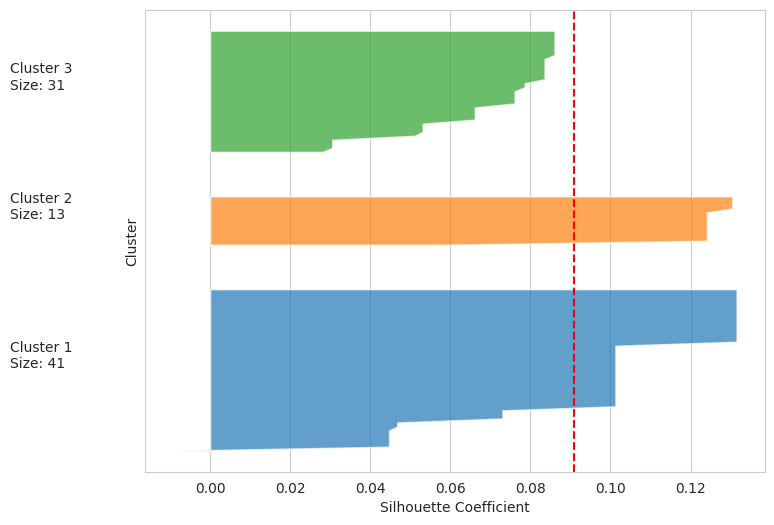

Combination 33:
Hyperparameters: ('average', 'russellrao', 5, 'maxclust')
Score: 0.0774



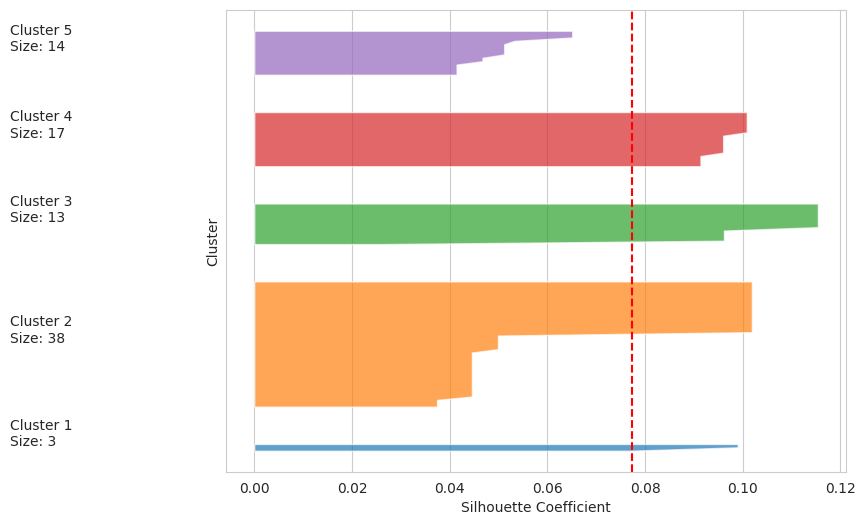

Combination 34:
Hyperparameters: ('complete', 'russellrao', 2, 'maxclust')
Score: 0.076



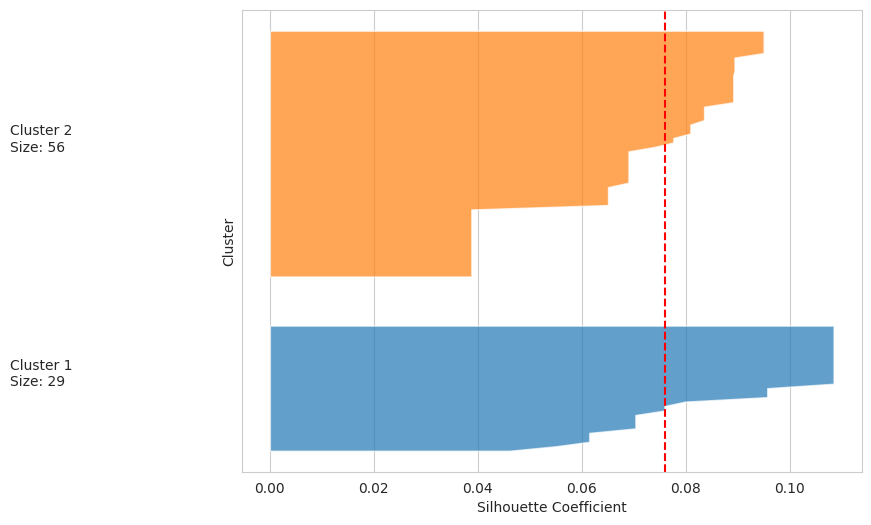

Combination 35:
Hyperparameters: ('average', 'russellrao', 2, 'maxclust')
Score: 0.076



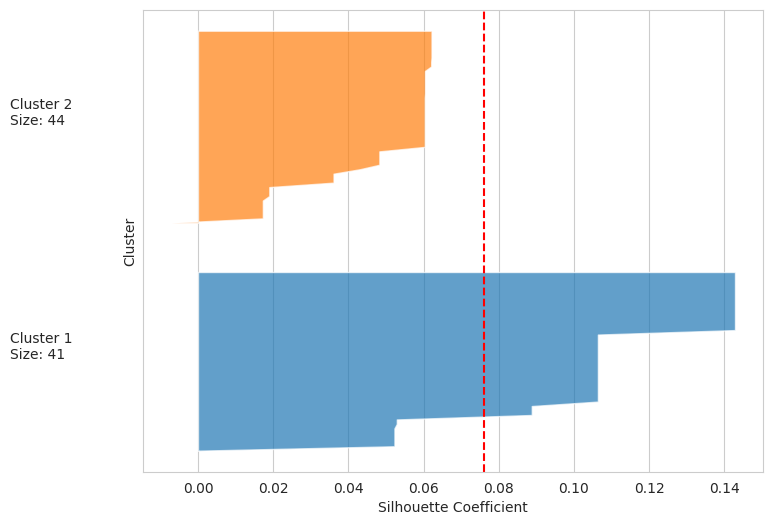

In [ ]:
# Print the top 20 combinations and their scores
for i, combination in enumerate(sorted_combinations[:50]):
    params, score = combination
    print(f"Combination {i+1}:")
    print(f"Hyperparameters: {params}")
    print(f"Score: {score}")
    print()

    # Create silhouette plot
    plt.figure(figsize=(8, 6))
    silhouette_values = silhouette_samples(data, labels_dict[params], metric=params[1])
    y_lower = 10
    for j in range(params[2]):
        cluster_silhouette_values = silhouette_values[labels_dict[params] == (j+1)]
        cluster_silhouette_values.sort()
        size_cluster_j = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_j, f"Cluster {j + 1}\nSize: {size_cluster_j}")
        y_lower = y_upper + 10

    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.axvline(x=score, color="red", linestyle="--")
    plt.yticks([])
    plt.show()

## Hyperparameter Tuning After Cluster Size Determined

In [ ]:
n_clusters = 3

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples

def hierarchical_clustering_exhaustive_search(data, hyperparameters):
    results = {}
    labels_dict = {}  # Store labels for each combination

    # Generate all combinations of hyperparameters
    parameter_combinations = list(itertools.product(*hyperparameters.values()))

    for combination in parameter_combinations:

        # Perform hierarchical clustering with the current combination of hyperparameters
        linkage_matrix = linkage(data, method=combination[0], metric=combination[1])
        labels = fcluster(linkage_matrix, t=n_clusters, criterion=combination[2])

        try:
            # Check if there is any empty cluster
            if labels.max() == 1 or len(np.unique(labels)) < n_clusters:
                # Skip this combination if it produces empty clusters or only one cluster
                continue

            # Compute the general silhouette score
            silhouette_score_val = silhouette_score(data, labels, metric=combination[1]).round(4)

            # Store the current combination and its corresponding score in the dictionary
            results[combination] = silhouette_score_val

            # Store the labels for this combination
            labels_dict[combination] = labels

        except ValueError:
            # Skip this combination if any other ValueErrors occur
            continue

    # Sort the combinations and scores in descending order of scores
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

    return sorted_results, labels_dict



# Define your hyperparameters
hyperparameters = {
    'method': ['single', 'complete', 'average'],  # Different linkage methods
    'metric': ['jaccard', 'dice', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'yule'], # Different distance metrics
    'criterion': ['distance', 'maxclust']          # Different criteria for forming flat clusters
}


data = np.array(df_no_outlier, dtype=bool)

# Perform hierarchical clustering with exhaustive search
sorted_combinations, labels_dict = hierarchical_clustering_exhaustive_search(data, hyperparameters)

# Print the top 20 combinations and their scores
for i, combination in enumerate(sorted_combinations[:50]):
    params, score = combination
    print(f"Combination {i+1}: {params}, Score: {score}")

Combination 1: ('average', 'yule', 'maxclust'), Score: 0.7165
Combination 2: ('average', 'dice', 'maxclust'), Score: 0.5177
Combination 3: ('average', 'rogerstanimoto', 'maxclust'), Score: 0.4774
Combination 4: ('average', 'sokalmichener', 'maxclust'), Score: 0.4774
Combination 5: ('average', 'jaccard', 'maxclust'), Score: 0.4402
Combination 6: ('average', 'sokalsneath', 'maxclust'), Score: 0.3707
Combination 7: ('average', 'russellrao', 'maxclust'), Score: 0.0908


## Running Hierarchical with Best Hyperparameters Excluding Negative Silhouette Scores

In [ ]:
def compute_silhouette_scores(data, n_clusters):
    # Compute the linkage matrix
    linkage_matrix = linkage(data, method='average', metric='yule')

    # Assign cluster labels based on the specified number of clusters
    labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

    # Compute the silhouette scores for each sample using the pairwise distances
    silhouette_vals = silhouette_samples(data, labels, metric='yule')

    # Compute the general silhouette score
    silhouette_score_val = silhouette_score(data, labels, metric='yule')

    return labels, silhouette_vals, silhouette_score_val


# Define data
data = np.array(df_no_outlier, dtype=bool)

# Initialize a flag to track if negative silhouette scores are present
negative_scores_present = True

# Initialize a counter for the iteration
iteration = 1

# Loop until no new negative silhouette scores are found
while negative_scores_present:
    labels, sample_silhouette_scores, average_silhouette_score = compute_silhouette_scores(data, n_clusters)

    # Print the average silhouette score on the filtered data at each iteration
    print(f"Iteration {iteration}: Average Silhouette Score (Filtered): {sample_silhouette_scores.mean():.3f}")
    print()

    # Check if there are negative silhouette scores
    negative_indices = np.where(sample_silhouette_scores < 0)[0]
    if negative_indices.size > 0:
        # Remove cases with negative silhouette scores
        df_no_outlier = df_no_outlier.drop(df_no_outlier.index[negative_indices])
        # Update the data to exclude the rows with negative silhouette scores
        data = np.array(df_no_outlier, dtype=bool)
    else:
        negative_scores_present = False

    iteration += 1

# Final silhouette scores after filtering
labels, sample_silhouette_scores, average_silhouette_score = compute_silhouette_scores(data, n_clusters)
print(f"Final Average Silhouette Score (Filtered): {sample_silhouette_scores.mean():.3f}")
print(f"Final Average Silhouette Score (Double-Check) (Filtered): {average_silhouette_score:.3f}")

Iteration 1: Average Silhouette Score (Filtered): 0.716

Iteration 2: Average Silhouette Score (Filtered): 0.684

Iteration 3: Average Silhouette Score (Filtered): 0.771

Final Average Silhouette Score (Filtered): 0.771
Final Average Silhouette Score (Double-Check) (Filtered): 0.771


In [ ]:
labels

array([2, 3, 1, 1, 2, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3,
       2, 1, 1, 1, 3, 3, 2, 3, 2, 2, 1, 3, 2, 1, 2, 1, 2, 1, 1, 2, 3, 1,
       1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 2, 2, 3,
       3, 1, 2, 1, 1, 1, 3, 1, 3, 3, 3, 1], dtype=int32)

## Silhouette Plot

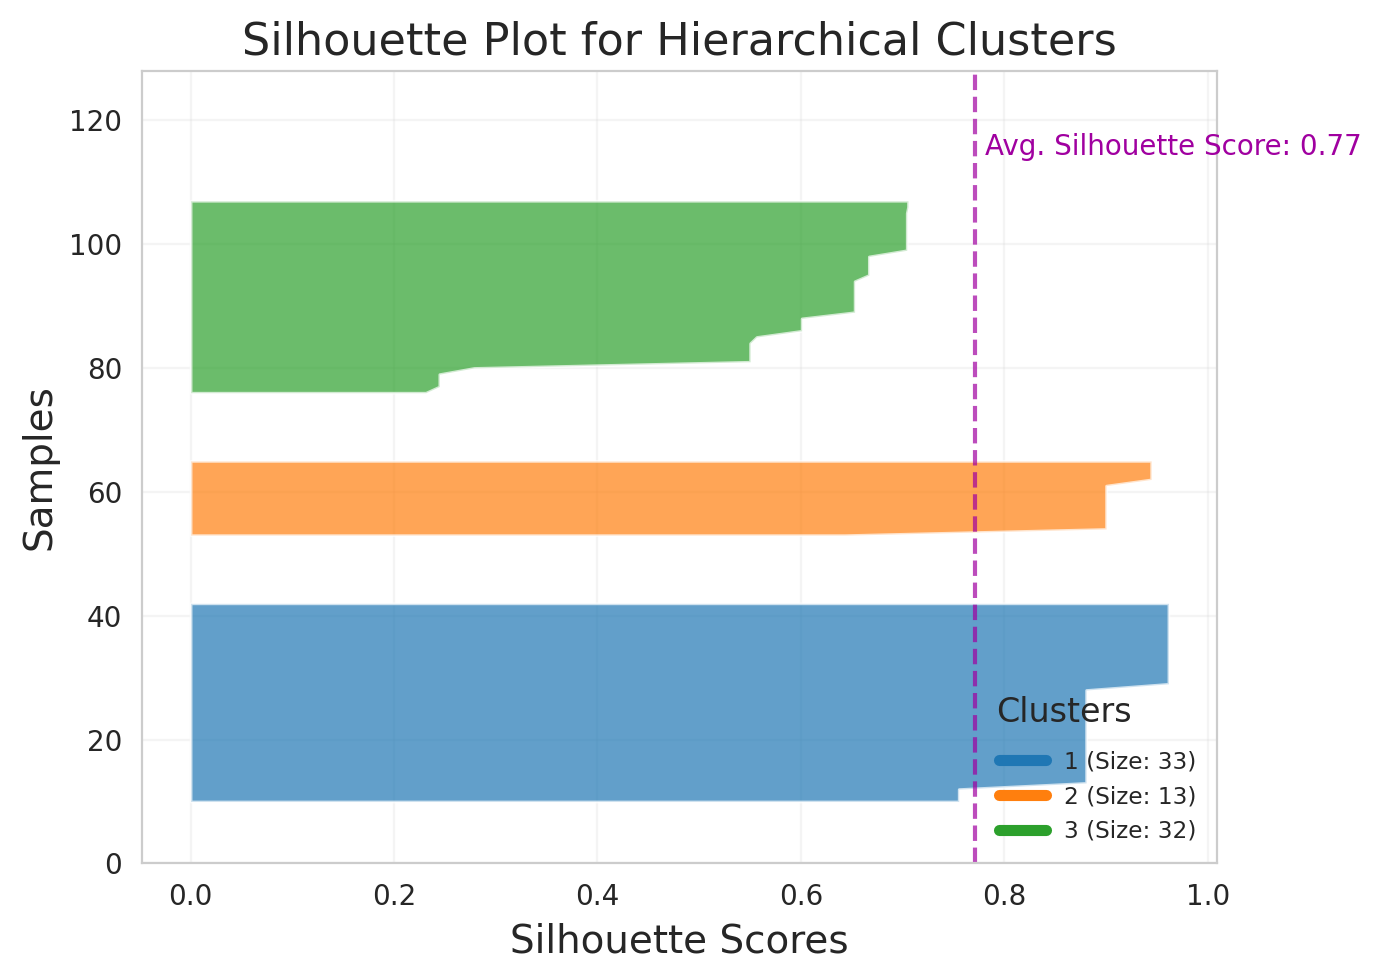

In [ ]:
from scipy.cluster import hierarchy
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

def silhouette_plot(data, labels, silhouette_vals, average_silhouette_score):
    # Set the figure size and resolution
    plt.figure(figsize=(7, 5), dpi=200)

    # Set the seaborn style
    sns.set_style("whitegrid")

    # Get the cluster sizes
    cluster_sizes = [sum(labels == i) for i in range(1, n_clusters + 1)]

    # Create a custom colormap using a seaborn color palette
    cluster_colors = sns.color_palette('tab10', n_colors=n_clusters)

    # Initialize variables for positioning the silhouette plots
    y_lower = 10

    # Create subplots for each cluster
    for cluster_num in range(1, n_clusters + 1):
        cluster_indices = (labels == cluster_num)
        cluster_silhouette_scores = silhouette_vals[cluster_indices]
        cluster_silhouette_scores.sort()

        cluster_size = cluster_sizes[cluster_num - 1]
        y_upper = y_lower + cluster_size

        # Fill the silhouette plot with the cluster color
        color = cluster_colors[cluster_num - 1]
        plt.fill_betweenx(range(y_lower, y_upper), 0, cluster_silhouette_scores, facecolor=color, alpha=0.7)

        # Compute the new y_lower for the next plot
        y_lower = y_upper + 10

    # Add legend
    legend_patches = [Line2D([0], [0], color=cluster_colors[cluster_num - 1], lw=4, label=f'{cluster_num} (Size: {cluster_sizes[cluster_num - 1]})') for cluster_num in range(1, n_clusters + 1)]
    legend = plt.legend(handles=legend_patches, loc='lower right', title=" ", fontsize='small', frameon=False)
    plt.text(0.92, 0.19, 'Clusters', ha='right', va='center', transform=plt.gca().transAxes, fontsize=12)

    # Set plot aesthetics
    plt.xlabel("Silhouette Scores", fontsize=14)
    plt.ylabel("Samples", fontsize=14)
    plt.axvline(x=average_silhouette_score, color="#A000A0", linestyle="--", alpha=0.7)  # Average silhouette score
    plt.text(average_silhouette_score + 0.01, np.mean(cluster_sizes) * 4.4, "Avg. Silhouette Score: {:.2f}".format(average_silhouette_score), color="#A000A0")  # Display the average silhouette score
    plt.title("Silhouette Plot for Hierarchical Clusters", fontsize=16)

    # Set the y-axis range
    plt.ylim(0, y_upper + 20)

    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

# Assuming you have defined taxo_df_dum, labels, sample_silhouette_scores, and average_silhouette_score
silhouette_plot(data, labels, sample_silhouette_scores, average_silhouette_score)

## Intrepretation

In [ ]:
# Add the cluster labels to the original data frame
df_with_clusters = pd.DataFrame(data, columns=df_no_outlier.columns)
df_with_clusters['Cluster'] = labels

# Examine cluster characteristics
for cluster_id in range(1, n_clusters+1):
    cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster_id]

    # Example: For dummy variables, calculate the frequency of each dummy variable in the cluster
    cluster_frequency = cluster_data.mean()

    print(f"Cluster {cluster_id} Characteristics:")
    print(cluster_frequency)
    print()


In [ ]:
cluster_groups = df_with_clusters.groupby('Cluster').mean()
cluster_groups

,Algorithm_DPoS,Algorithm_Equihash,Algorithm_Multiple,Algorithm_PoS,Algorithm_Quark,Algorithm_SHA-256,Algorithm_Scrypt,Algorithm_X11,ProofType_DPoS,ProofType_PoS,...,ProofType_PoW/PoS,Access_Permissioned,Access_Permissionless,FINMA_Payment,"FINMA_Payment,Utility",FINMA_Utility,"Industry_Arts, Entertainment and Recreation",Industry_Blockchain-Specific Application,Industry_Financial and Insurance Activities,"Industry_Professional, Scientific and Technical Activities"
Cluster,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.111111,0.0,0.111111,0.444444,0.333333,0.000000,0.0,0.0,...,0.444444,0.111111,0.888889,0.000000,0.000000,1.0,0.111111,0.555556,0.000000,0.333333
2,0.0,0.000000,0.000000,0.8,0.200000,0.000000,0.000000,0.000000,0.0,1.0,...,0.000000,0.360000,0.640000,0.000000,0.000000,1.0,0.000000,0.160000,0.840000,0.000000
3,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.0,...,0.000000,0.363636,0.636364,0.000000,0.000000,1.0,0.090909,0.363636,0.454545,0.090909
4,0.0,0.176471,0.058824,0.0,0.058824,0.411765,0.235294,0.058824,0.0,0.0,...,0.235294,0.000000,1.000000,0.823529,0.176471,0.0,0.000000,0.000000,1.000000,0.000000
5,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.0,...,0.600000,1.000000,0.000000,0.000000,0.400000,0.6,0.200000,0.000000,0.800000,0.000000


In [ ]:
df_with_clusters = pd.DataFrame(data, columns=df_no_outlier.columns)
df_with_clusters = df_with_clusters.astype(int)
df_with_clusters['Cluster'] = labels
df_with_clusters.head()

,Algorithm_DPoS,Algorithm_Equihash,Algorithm_Multiple,Algorithm_PoS,Algorithm_Quark,Algorithm_SHA-256,Algorithm_Scrypt,Algorithm_X11,ProofType_DPoS,ProofType_PoS,ProofType_PoW,ProofType_PoW/PoS,Access_Permissioned,Access_Permissionless,Cluster
0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,2
1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,3
2,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1
3,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1
4,1,0,0,0,0,0,0,0,1,0,0,0,0,1,2


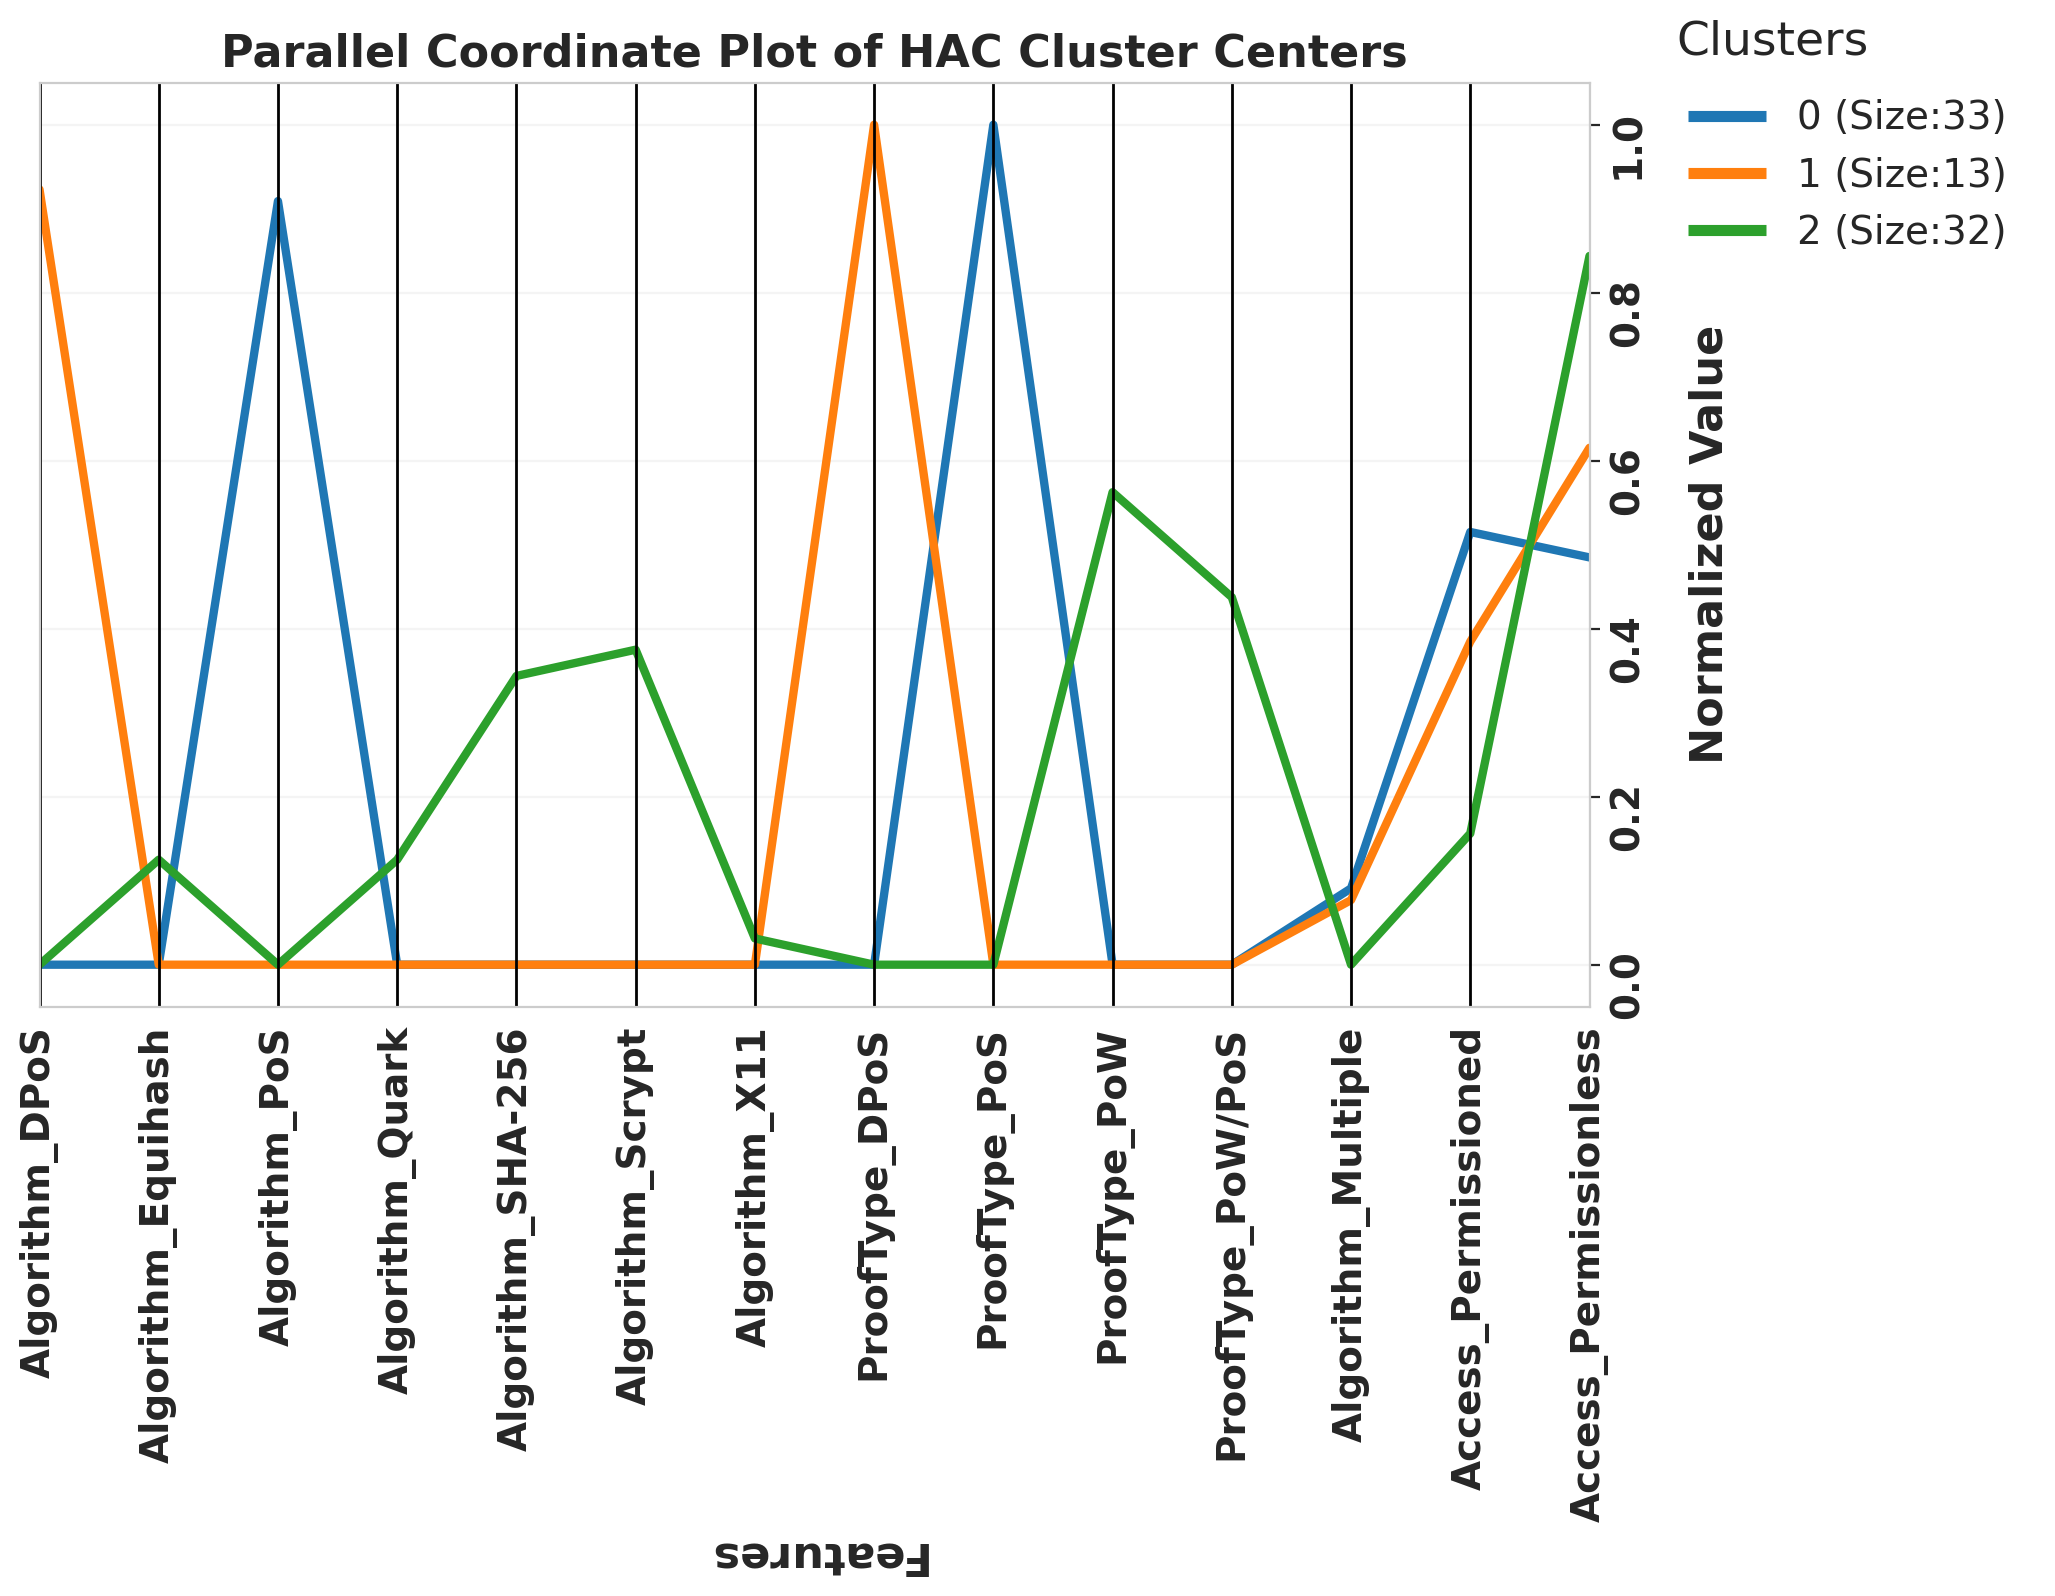

In [ ]:
from matplotlib.lines import Line2D
import seaborn as sns  # Import seaborn to use its colormaps

def plot_parallel_coordinates(data, labels):
    data_copy = data.copy()

    data_array = data.values

    # Calculate the centroids
    centroids = []
    for cluster_label in range(1, n_clusters + 1):
        cluster_points = data_array[labels == cluster_label]
        cluster_centroid = cluster_points.mean(axis=0)
        centroids.append(cluster_centroid)
    centroids = np.array(centroids)

    df_centroids = pd.DataFrame(centroids, columns=data_copy.columns)
    df_centroids['Cluster'] = ['Cluster {}'.format(i) for i in range(len(df_centroids))]
    cluster_sizes = [np.sum(labels == (i + 1)) for i in range(len(df_centroids))]

    # Calculate minimum pairwise difference between clusters for each feature
    feature_diff_min = df_centroids.iloc[:, :-1].apply(lambda x: np.min([np.abs(x[i] - x[j]) for i in range(len(x)) for j in range(i+1, len(x))]), axis=0)

    # Sort features based on minimum pairwise difference
    sorted_features = feature_diff_min.sort_values(ascending=True).index

    # Set the figure size and resolution
    fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

    # Define a colormap based on the number of clusters
    num_clusters = len(df_centroids)
    colors = sns.color_palette("tab10", n_colors=num_clusters)

    pd.plotting.parallel_coordinates(df_centroids, 'Cluster', cols=sorted_features, ax=ax, color=colors,
                                     xticks=None, colormap=None, axvlines=True, axvlines_kwds=None,
                                     sort_labels=False, linewidth=3)

    # Move the y-axis to the right
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")

    ax.set_xlabel('Features', fontsize=16, rotation=180, weight='bold')
    ax.set_ylabel('Normalized Value', fontsize=16, labelpad=15, weight='bold')
    ax.set_title('Parallel Coordinate Plot of HAC Cluster Centers', fontsize=16, weight='bold')

    plt.xticks(rotation=90, fontsize=14, weight='bold')
    plt.yticks(fontsize=14, rotation=90, weight='bold')

    # Increase the width of line symbols in the legend
    lines_legend = [Line2D([0], [0], color=c, linewidth=4, linestyle='-', solid_capstyle='butt') for c in colors]
    legend = ax.legend(lines_legend, ['{} (Size:{}) '.format(i, size) for i, size in zip(range(len(df_centroids)), cluster_sizes)], loc='upper right', bbox_to_anchor=(1.30, 1.02), fontsize=14, frameon=False)  # Here you set the fontsize for the legend

    # Add title to the legend using annotation
    ax.annotate('Clusters', xy=(1.18, 1.03), xycoords='axes fraction', fontsize=17, ha='right')
    plt.grid(True, alpha=0.2)


    plt.show()

# Assuming 'n_clusters' is defined before calling the function
plot_parallel_coordinates(df_with_clusters, labels)


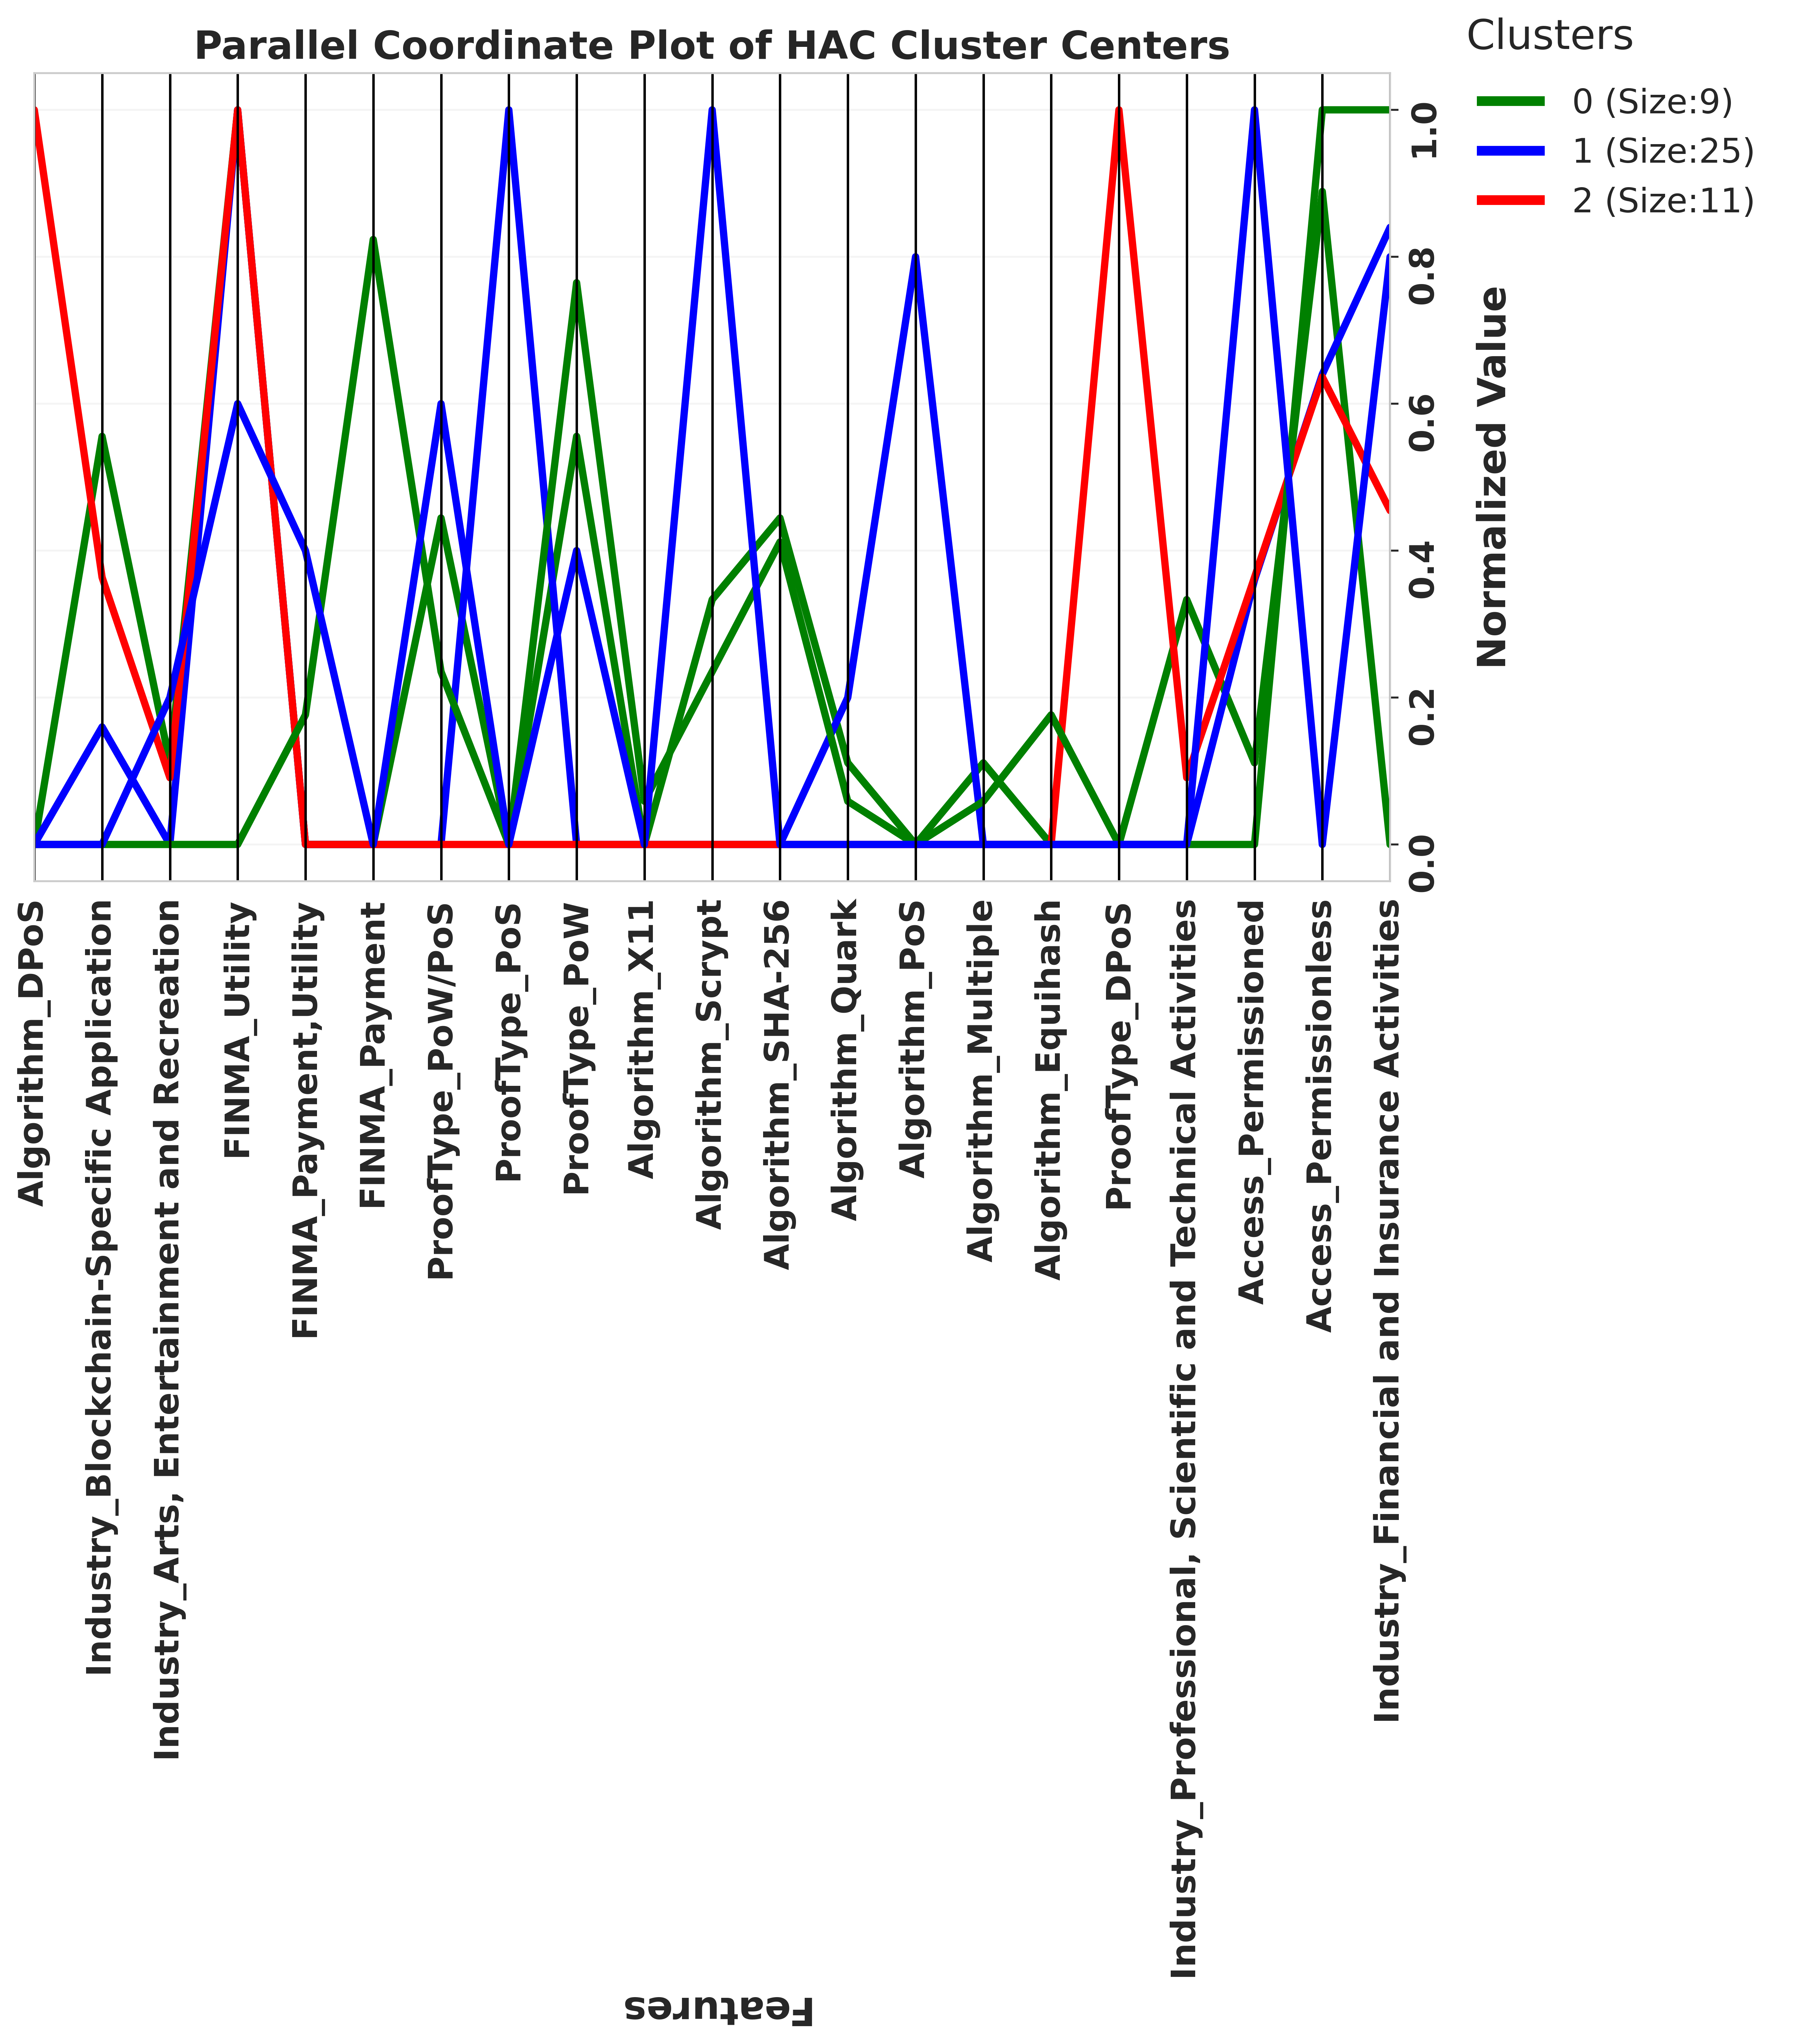

In [ ]:
from matplotlib.lines import Line2D

def plot_parallel_coordinates(data, labels):
    data_copy = data.copy()
    #data_copy.columns = feature_labels

    data_array = data.values

    # Calculate the centroids
    centroids = []
    for cluster_label in range(1, n_clusters + 1):
        cluster_points = data_array[labels == cluster_label]
        cluster_centroid = cluster_points.mean(axis=0)
        centroids.append(cluster_centroid)
    centroids = np.array(centroids)


    df_centroids = pd.DataFrame(centroids, columns=data_copy.columns)
    df_centroids['Cluster'] = ['Cluster {}'.format(i) for i in range(len(df_centroids))]
    cluster_sizes = [np.sum(labels == (i + 1)) for i in range(len(df_centroids))]



    # Calculate minimum pairwise difference between clusters for each feature
    feature_diff_min = df_centroids.iloc[:, :-1].apply(lambda x: np.min([np.abs(x[i] - x[j]) for i in range(len(x)) for j in range(i+1, len(x))]), axis=0)

    # Sort features based on minimum pairwise difference
    sorted_features = feature_diff_min.sort_values(ascending=True).index

    # Set the figure size and resolution
    fig, ax = plt.subplots(figsize=(10, 6), dpi=500)


    pd.plotting.parallel_coordinates(df_centroids, 'Cluster', cols=sorted_features, ax=ax, color=['green', 'blue', 'red'],
                                     xticks=None, colormap=None, axvlines=True, axvlines_kwds=None,
                                     sort_labels=False, linewidth=3)

    # Move the y-axis to the right
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")

    ax.set_xlabel('Features', fontsize=16, rotation=180, weight='bold')
    ax.set_ylabel('Normalized Value', fontsize=16, labelpad=15, weight='bold')
    ax.set_title('Parallel Coordinate Plot of HAC Cluster Centers', fontsize=16, weight='bold')

    plt.xticks(rotation=90, fontsize=14, weight='bold')
    plt.yticks(fontsize=14, rotation=90, weight='bold')


    # Increase the width of line symbols in the legend
    lines_legend = [Line2D([0], [0], color=c, linewidth=4, linestyle='-', solid_capstyle='butt') for c in ['green', 'blue', 'red']]
    legend = ax.legend(lines_legend, ['{} (Size:{}) '.format(i, size) for i, size in zip(range(len(df_centroids)), cluster_sizes)], loc='upper right', bbox_to_anchor=(1.30, 1.02), fontsize=14, frameon=False)  # Here you set the fontsize for the legend

    # Add title to the legend using annotation
    ax.annotate('Clusters', xy=(1.18, 1.03), xycoords='axes fraction', fontsize=17, ha='right')
    plt.grid(True, alpha=0.2)

    # Save the figure before you call plt.show()
    plt.savefig('parallel_coordinates.png', bbox_inches='tight', dpi=500)
    plt.show()


plot_parallel_coordinates(df_with_clusters, labels)